# **Import libraries**

In [1]:
# Standard Library Imports
import os
from ast import literal_eval

# Data Manipulation and Processing Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

sns.set_style("white")
sns.set_context("poster",font_scale = .7)

palette = ["#1d7874","#679289","#f4c095","#ee2e31","#ffb563","#918450","#f85e00","#a41623","#9a031e","#d6d6d6","#ffee32","#ffd100","#333533","#202020"]

# Text Processing Libraries
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

# Machine Learning and Statistical Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, pairwise
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, sigmoid_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, KFold

import tensorflow as tf
import keras

import warnings
warnings.filterwarnings('ignore')

# **Read dataset**

## **Anime Dataset**

In [2]:
anime = pd.read_csv(r'anime/anime.csv', low_memory=False)

def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime["name"] = anime["name"].apply(text_cleaning)

anime['episodes'] = anime['episodes'].apply(lambda x: np.nan if x == 'Unknown' else x)

anime['genre'] = anime['genre'].apply(lambda x: None if pd.isna(x) else [genre.strip() for genre in str(x).split(',')])
anime['genre'] = anime['genre'].apply(lambda x: tuple(x) if isinstance(x, list) else x)


anime.dropna(inplace=True)
anime.drop_duplicates(inplace=True)
anime.drop_duplicates(subset=['anime_id', 'name'], inplace=True)

anime['genre'] = anime['genre'].apply(lambda x: list(x) if isinstance(x, tuple) else x)

anime['episodes'] = anime['episodes'].astype('int')

### dataframe information

In [3]:
print(f'Shape of the dataframe: {anime.shape}')

print('\n')

print(f'columns: {anime.columns.to_list()}')

anime.head(2)

Shape of the dataframe: (11830, 7)


columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665


In [4]:
print('Information about the dataframe: ')
anime.info()

Information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
Index: 11830 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11830 non-null  int64  
 1   name      11830 non-null  object 
 2   genre     11830 non-null  object 
 3   type      11830 non-null  object 
 4   episodes  11830 non-null  int32  
 5   rating    11830 non-null  float64
 6   members   11830 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 693.2+ KB


## **Rating Dataset**

In [5]:
rating = pd.read_csv(r'anime/rating.csv', low_memory=False)

In [6]:
def filter_active_users(rating, min_ratings=300):
    # Count ratings per user
    user_rating_counts = rating['user_id'].value_counts()
    
    # Get users who have rated at least min_ratings items
    active_users = user_rating_counts[user_rating_counts >= min_ratings].index
    
    # Filter the original dataframe to keep only active users
    filtered_df = rating[rating['user_id'].isin(active_users)]
    
    # Print some statistics
    print(f"Original number of users: {rating['user_id'].nunique()}")
    print(f"Number of users with {min_ratings}+ ratings: {len(active_users)}")
    print(f"Original number of ratings: {len(rating)}")
    print(f"Number of ratings after filtering: {len(filtered_df)}")
    
    return filtered_df

In [7]:
rating["rating"].replace(to_replace = -1 , value = np.nan ,inplace=True)
rating.dropna(inplace=True)

rating.drop_duplicates(subset=['anime_id', 'user_id'], inplace=True)

rating = filter_active_users(rating, min_ratings=100)

Original number of users: 69600
Number of users with 100+ ratings: 19949
Original number of ratings: 6337234
Number of ratings after filtering: 4763011


### dataframe information

In [8]:
print(f'Shape of the dataframe: {rating.shape}')

print('\n')

print(f'columns: {rating.columns.to_list()}')

rating.head(2)

Shape of the dataframe: (4763011, 3)


columns: ['user_id', 'anime_id', 'rating']


,user_id,anime_id,rating
302,5,6,8.0
303,5,15,6.0


In [9]:
print('Information about the dataframe: ')
rating.info()

Information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
Index: 4763011 entries, 302 to 7813734
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 145.4 MB


## **Merge the **anime** and **rating** datasets.**

In [10]:
anime_rating = pd.merge(anime,rating,on="anime_id",suffixes= [None, "_user"])
anime_rating = anime_rating.rename(columns={"rating_user": "user_rating"})

### dataframe information

In [11]:
print(f'Shape of the dataframe: {anime_rating.shape}')

print('\n')

print(f'columns: {anime_rating.columns.to_list()}')

anime_rating.head(2)

Shape of the dataframe: (4762918, 9)


columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members', 'user_id', 'user_rating']


,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0


In [12]:
anime_rating.head(2)

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0


In [13]:
print('Information about the dataframe: ')
anime_rating.info()

Information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4762918 entries, 0 to 4762917
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     int32  
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  float64
dtypes: float64(2), int32(1), int64(3), object(3)
memory usage: 308.9+ MB


In [14]:
def process_anime_ratings(df):
    """
    Process anime ratings DataFrame to calculate vote averages and counts per anime.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing anime ratings with columns:
        - user_id
        - user_rating
        - anime_id
        (and potentially other columns)
    
    Returns:
    pandas.DataFrame: Processed DataFrame with vote_average and vote_count columns,
                     removed user columns, and deduplicated anime entries
    """
    # Calculate vote statistics per anime
    vote_stats = df.groupby('anime_id').agg({
        'user_rating': ['mean', 'count']
    }).reset_index()
    
    # Rename the aggregated columns
    vote_stats.columns = ['anime_id', 'vote_average', 'vote_count']
    
    # Round vote_average to 2 decimal places
    vote_stats['vote_average'] = vote_stats['vote_average'].round(2)
    
    # Merge vote statistics with original DataFrame
    result = pd.merge(df, vote_stats, on='anime_id', how='left')
    
    # Drop user-specific columns
    result = result.drop(['user_id', 'user_rating'], axis=1)
    
    # Remove duplicates based on anime_id
    result = result.drop_duplicates(subset=['anime_id'])
    
    return result


# **Knowledge based Recommender**

In [15]:
anime_df = anime_rating.copy()

## **Knowledge based Information**

### Create a new dataFrame for the mean of ratings for each product

In [16]:
average_rating_df = anime_df.groupby(['name']).agg({"user_rating":"mean"})['user_rating'].sort_values(ascending=False)

average_rating_df = average_rating_df.to_frame()

average_rating_df = average_rating_df.rename(columns={"user_rating": "average_rating"})

print(f'Shape of the dataframe: {average_rating_df.shape}')

average_rating_df.head(5)

Shape of the dataframe: (9849, 1)


,average_rating
name,
Ketsuinu,10.0
Konna Watashitachi ga Nariyuki de Heroine ni Natta Kekka www (TV),10.0
Yattokame Tanteidan,10.0
Dededen,10.0
Gozonji! Gekkou Kamen-kun,10.0


### Take the high of the frequently of the rated products

In [17]:
# Create a list of only the frequently watched movies
product_popularity = anime_df["name"].value_counts()
popular_product = product_popularity[product_popularity > 200].index # can use that code without .index to show the name and their counts

print(popular_product)

Index(['Death Note', 'Sword Art Online', 'Code Geass: Hangyaku no Lelouch',
       'Angel Beats!', 'Shingeki no Kyojin', 'Toradora!', 'Elfen Lied',
       'Code Geass: Hangyaku no Lelouch R2',
       'Fullmetal Alchemist: Brotherhood', 'Highschool of the Dead',
       ...
       'Is Pure Bonus', 'Manyuu Hikenchou Specials',
       'Tales of Symphonia The Animation: Kratos-sensei no Private Lesson',
       'Vipers Creed',
       'Futsuu no Joshikousei ga [Locodol] Yattemita.: Nagarekawa, Annai Shitemita.',
       'Full Moon wo Sagashite: Kawaii Kawaii Daibouken', 'City Hunter 2',
       'Ane☆Haramix', 'Otona Joshi no Anime Time',
       'Gakuen Utopia Manabi Straight! Special'],
      dtype='object', name='name', length=3074)


### Filter the original DataFrame to include only the popular products

In [18]:
# Use this popular_product list to filter the original DataFrame
popular_product_rankings = anime_df[anime_df["name"].isin(popular_product)]

# Inspect the product watched over 50 times
popular_product_rankings.head(3)

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10.0


### Find the top 5 popular products based on their average rating

In [19]:
# Find the average rating given to these frequently watched films
popular_product_average_rankings = popular_product_rankings[["name", "user_rating"]].groupby('name').mean()

popular_product_average_rankings = popular_product_average_rankings.rename(columns={"user_rating": "average_rating"})

popular_product_average_rankings.sort_values(by="average_rating", ascending=False).head()

,average_rating
name,
Gintama°,9.424926
Kimi no Na wa.,9.401404
Ginga Eiyuu Densetsu,9.368902
Fullmetal Alchemist: Brotherhood,9.284006
Steins;Gate,9.237603


## **Knowledge based Visualization**

In [20]:
anime_df.head(2)

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0


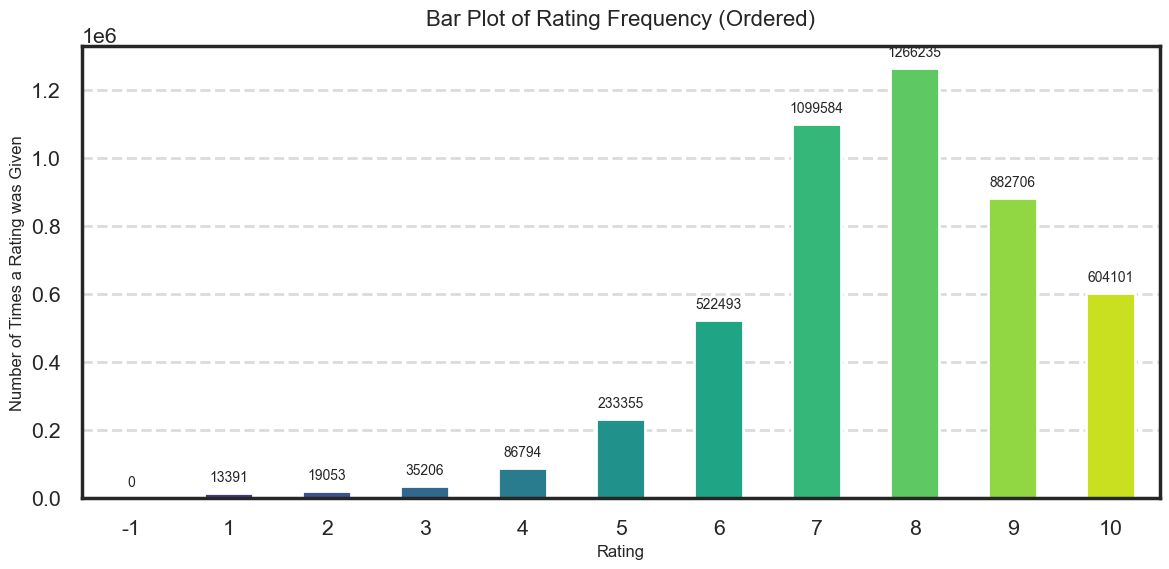

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the x-axis order and create the palette
x_order = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
palette = sns.color_palette("viridis", len(x_order))  # "husl" palette for diverse colors

# Count the ratings and reindex to ensure all values in x_order are present
rating_counts = anime_df['user_rating'].value_counts(sort=False).reindex(x_order, fill_value=0)

# Generate the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = rating_counts.plot(kind='bar', ax=ax, rot=0, color=palette)

# Title and labels
ax.set_title('Bar Plot of Rating Frequency (Ordered)', fontsize=16, pad=15)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Number of Times a Rating was Given', fontsize=12)

# Add value labels on the bars
for index, value in enumerate(rating_counts):
    ax.text(x=index, y=value + 0.02 * max(rating_counts), s=str(value), 
            ha='center', va='bottom', fontsize=10)

# Add gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [22]:
# Define the rating intervals and labels
rating_ranges = [
    (0, 1, "0 to 1 star"),
    (1, 2, "1 to 2 stars"),
    (2, 3, "2 to 3 stars"),
    (3, 4, "3 to 4 stars"),
    (4, 5, "4 to 5 stars"),
    (5, 6, "5 to 6 stars"),
    (6, 7, "6 to 7 stars"),
    (7, 8, "7 to 8 stars"),
    (8, 9, "8 to 9 stars"),
    (9, 10, "9 to 10 stars")
]

# Calculate the number of movies in each range
data = []
rating_objects = {}
for lower, upper, label in rating_ranges:
    count = len(average_rating_df[(average_rating_df['average_rating'] > lower) & (average_rating_df['average_rating'] <= upper)])
    filtered_movies = average_rating_df[(average_rating_df['average_rating'] > lower) & (average_rating_df['average_rating'] <= upper)]
    rating_objects[label] = filtered_movies  # Store the filtered DataFrame
    print(f"Number of movies with {label} rating on average: {len(filtered_movies)}")
    data.append({'Rating Range': label, 'Count': count})

Number of movies with 0 to 1 star rating on average: 34
Number of movies with 1 to 2 stars rating on average: 68
Number of movies with 2 to 3 stars rating on average: 222
Number of movies with 3 to 4 stars rating on average: 260
Number of movies with 4 to 5 stars rating on average: 541
Number of movies with 5 to 6 stars rating on average: 1349
Number of movies with 6 to 7 stars rating on average: 3353
Number of movies with 7 to 8 stars rating on average: 3346
Number of movies with 8 to 9 stars rating on average: 635
Number of movies with 9 to 10 stars rating on average: 41


In [23]:
rating_counts_df = pd.DataFrame(data)

# Plot the pie chart
fig = px.pie(rating_counts_df, values='Count', names='Rating Range',
             title='Distribution of Anime by Average Rating',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_traces(textinfo='percent+label')
fig.show()


In [24]:
popular_movies = anime_df.groupby(['name']).agg({"user_rating":"count"})['user_rating'].sort_values(ascending=False)

popular_movies = popular_movies.to_frame()
popular_movies.reset_index(level=0, inplace=True)
popular_movies.columns = ['name', 'Number of Users watched']

In [25]:
# Define viewer ranges and labels
viewer_ranges = [
    (600, float('inf'), "600+ viewers"),
    (500, 600, "500-599 viewers"),
    (400, 500, "400-499 viewers"),
    (300, 400, "300-399 viewers"),
    (200, 300, "200-299 viewers"),
    (100, 200, "100-199 viewers"),
    (50, 100, "50-99 viewers"),
    (20, 50, "20-49 viewers"),
    (-float('inf'), 20, "Less than 20 viewers"),
]

# Calculate the counts for each range
data = []
rating_objects = {}
for lower, upper, label in viewer_ranges:
    count = len(popular_movies[(popular_movies['Number of Users watched'] >= lower) & (popular_movies['Number of Users watched'] < upper)])
    filtered_movies = popular_movies[(popular_movies['Number of Users watched'] >= lower) & (popular_movies['Number of Users watched'] < upper)]
    rating_objects[label] = filtered_movies  # Store the filtered DataFrame
    print(f"Number of viewer between {label}: {len(filtered_movies)}")
    data.append({'Viewer Range': label, 'Count': count})

Number of viewer between 600+ viewers: 1838
Number of viewer between 500-599 viewers: 190
Number of viewer between 400-499 viewers: 273
Number of viewer between 300-399 viewers: 304
Number of viewer between 200-299 viewers: 474
Number of viewer between 100-199 viewers: 898
Number of viewer between 50-99 viewers: 1052
Number of viewer between 20-49 viewers: 1391
Number of viewer between Less than 20 viewers: 3429


In [26]:
# Create a DataFrame for the data
viewer_counts_df = pd.DataFrame(data)

# Plot the pie chart
fig = px.pie(viewer_counts_df, values='Count', names='Viewer Range',
             title='Distribution of Popular Movies by Viewer Count',
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_traces(textinfo='percent+label')
fig.show()

In [27]:
popular_movies[popular_movies['Number of Users watched'] >= 400].head(2)

,name,Number of Users watched
0,Death Note,14501
1,Sword Art Online,13165


In [28]:
highly_rated_popular_movies = pd.merge(average_rating_df, popular_movies, how = 'inner', on='name')
highly_rated_popular_movies.head(10)

,name,average_rating,Number of Users watched
0,Ketsuinu,10.0,1
1,Konna Watashitachi ga Nariyuki de Heroine ni N...,10.0,1
2,Yattokame Tanteidan,10.0,1
3,Dededen,10.0,1
4,Gozonji! Gekkou Kamen-kun,10.0,1
5,Kanagatari. Kanabakari.: Kanadian Families,10.0,1
6,Kawasaki Frontale x Tentai Senshi Sunred 2nd S...,10.0,1
7,Kero Kero Keroppi no Kero Kero House no Himitsu,10.0,1
8,Choegang Top Plate,10.0,1
9,Kamiusagi Rope x Panasonic Collaboration,10.0,1


In [29]:
highly_rated_popular_movies[highly_rated_popular_movies['Number of Users watched'] >= 200].head(10)

,name,average_rating,Number of Users watched
28,Gintama°,9.424926,1019
29,Kimi no Na wa.,9.401404,1425
30,Ginga Eiyuu Densetsu,9.368902,656
31,Fullmetal Alchemist: Brotherhood,9.284006,11292
32,Steins;Gate,9.237603,10446
33,Gintama,9.223783,5483
34,Hunter x Hunter (2011),9.202803,4709
35,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,9.180516,1745
36,Gintama: Enchousen,9.178470,1765
37,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.147740,907


In [30]:
highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>=200) & (highly_rated_popular_movies['average_rating']>=7.0)].sort_values(by='average_rating', ascending=False).head(10)

,name,average_rating,Number of Users watched
28,Gintama°,9.424926,1019
29,Kimi no Na wa.,9.401404,1425
30,Ginga Eiyuu Densetsu,9.368902,656
31,Fullmetal Alchemist: Brotherhood,9.284006,11292
32,Steins;Gate,9.237603,10446
33,Gintama,9.223783,5483
34,Hunter x Hunter (2011),9.202803,4709
35,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,9.180516,1745
36,Gintama: Enchousen,9.178470,1765
37,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.147740,907


### Recommendations based on Movie Genre to a New User.

In [31]:
items_dataset = anime.copy()

In [32]:
# Extract unique genres
unique_genres = set(genre for genres in items_dataset['genre'] for genre in genres)

# Create a column for each genre with binary encoding
for genre in unique_genres:
    items_dataset[genre] = items_dataset['genre'].apply(lambda genres: 1 if genre in genres else 0)

# Drop the original genres column if no longer needed
items_dataset = items_dataset.drop(columns=['genre'])

In [33]:
movie_genre_list = items_dataset.columns[6:].tolist()
movie_genre_list

['Thriller',
 'Magic',
 'Mecha',
 'Supernatural',
 'Vampire',
 'Ecchi',
 'Dementia',
 'Romance',
 'Drama',
 'Harem',
 'Horror',
 'Demons',
 'Shoujo Ai',
 'Seinen',
 'Game',
 'Sci-Fi',
 'Police',
 'Shoujo',
 'Historical',
 'Hentai',
 'Yuri',
 'Psychological',
 'Action',
 'Fantasy',
 'Music',
 'Samurai',
 'Kids',
 'Cars',
 'Sports',
 'Parody',
 'Space',
 'School',
 'Slice of Life',
 'Shounen',
 'Adventure',
 'Mystery',
 'Yaoi',
 'Josei',
 'Shounen Ai',
 'Super Power',
 'Martial Arts',
 'Comedy',
 'Military']

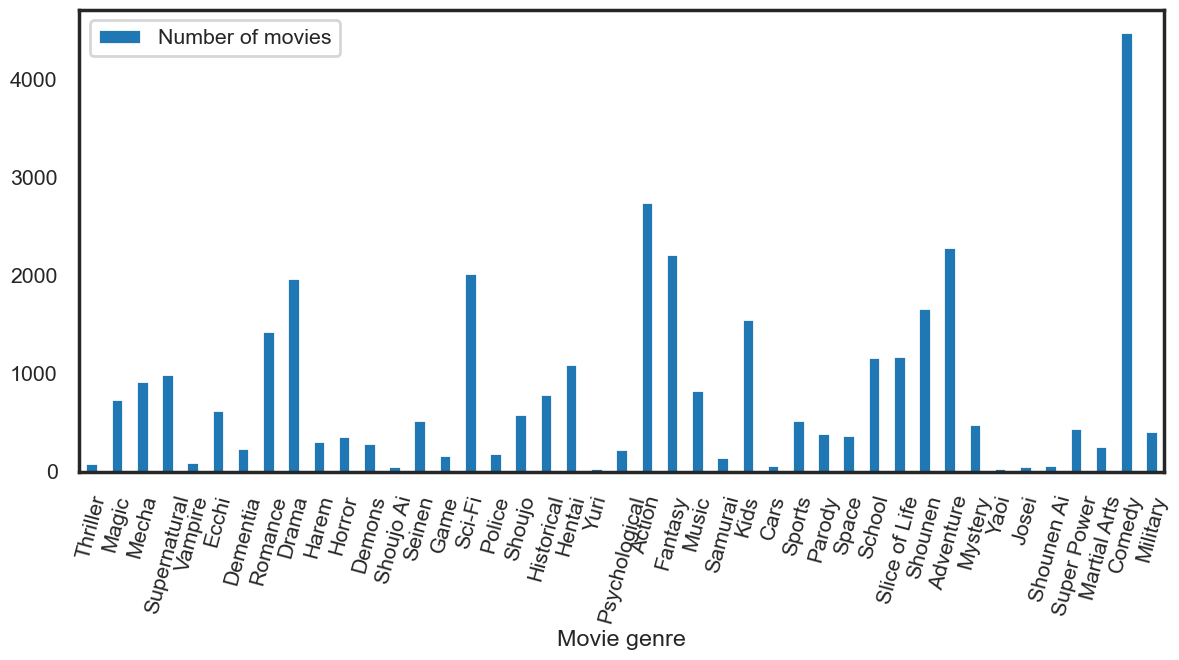

In [34]:
count = []
for i in movie_genre_list:
    # print(i)
    genre_based_movies = items_dataset[['anime_id','name',i]]
    genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
    count.append(len(genre_based_movies))
    # merged_genre_movies = pd.merge(dataset, genre_based_movies, how='inner', on='movie id')
    # star_based_visualization(merged_genre_movies)
df_plot = pd.DataFrame({'Movie genre':movie_genre_list, 'Number of movies':count})
ax = df_plot.plot.bar(x='Movie genre', y='Number of movies', rot=75, figsize=(14, 6))

In [35]:
# Filter rows where 'genre' contains both 'Adventure' or 'Action'
filtered_df = anime[anime['genre'].str.contains('Adventure') | anime['genre'].str.contains('Action')]

top_anime = anime.copy()

In [36]:
top_anime_temp3 = top_anime[["genre"]].copy()
top_anime_temp3["genre"] = top_anime_temp3["genre"].apply(lambda x: [g.strip().title() for g in x])
top_anime_temp3 = top_anime_temp3.explode("genre")

print(f'Total unique genres are {len(top_anime_temp3["genre"].unique())}')
print(f'Occurances of unique genres :')
top_anime_temp3["genre"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Total unique genres are 43
Occurances of unique genres :


genre,Comedy,Action,Adventure,Fantasy,Sci-Fi,Drama,Shounen,Kids,Romance,Slice Of Life,School,Hentai,Supernatural,Mecha,Music,Historical,Magic,Ecchi,Shoujo,Seinen,Sports,Mystery,Super Power,Military,Parody,Space,Horror,Harem,Demons,Martial Arts,Dementia,Psychological,Police,Game,Samurai,Vampire,Thriller,Cars,Shounen Ai,Shoujo Ai,Josei,Yuri,Yaoi
count,4483,2748,2293,2219,2028,1972,1669,1550,1436,1180,1164,1099,993,927,832,787,742,627,587,530,527,482,445,415,397,376,360,312,287,258,238,226,194,170,145,100,86,71,62,54,52,41,37


Let's explore how genre's wordcloud looks like



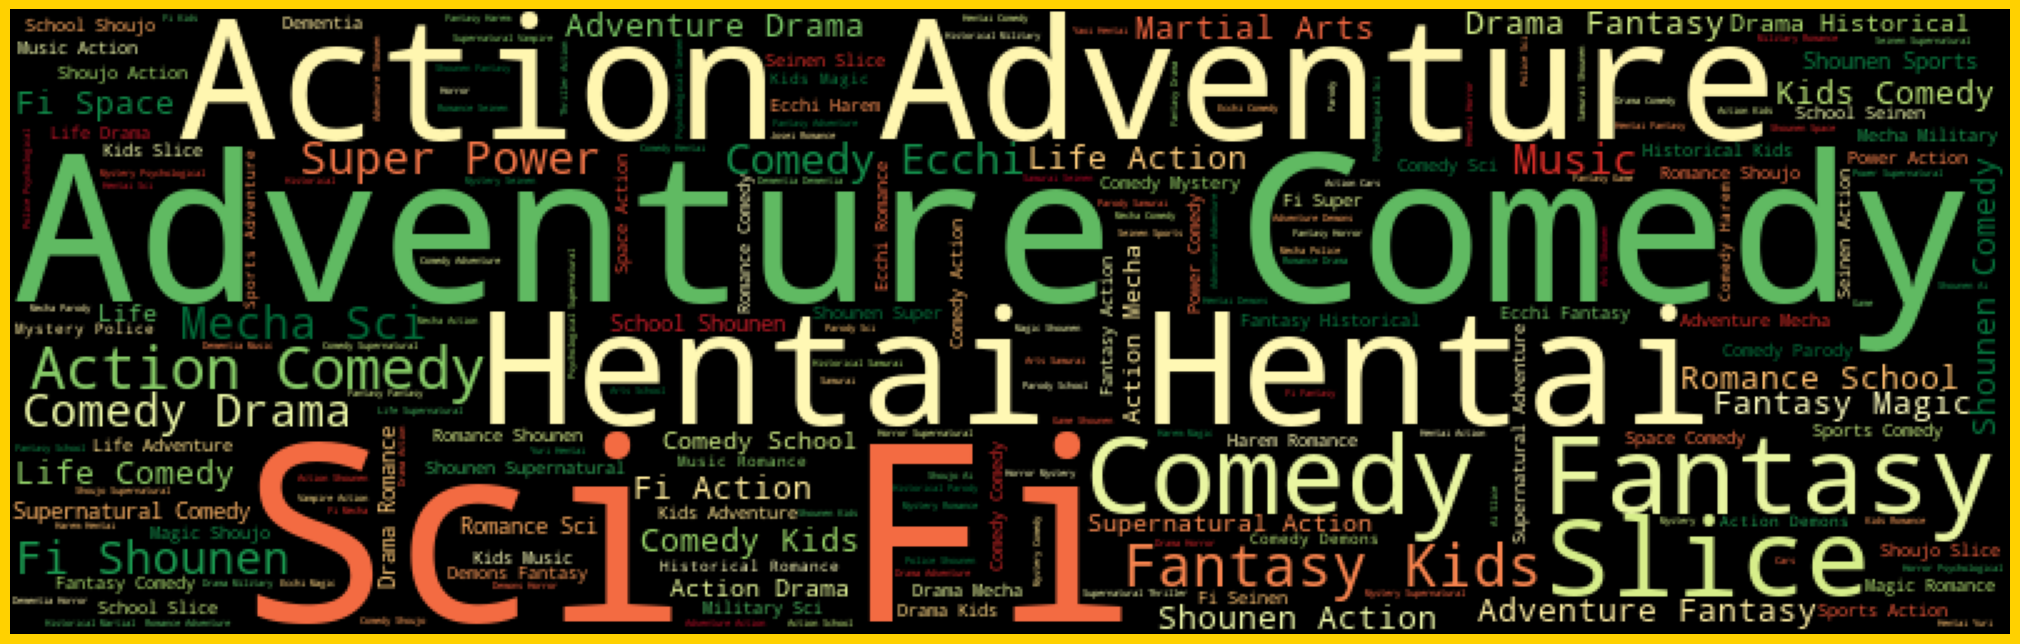

In [37]:

# Flatten the list of genres into a single string for word cloud generation
genre_text = ", ".join([", ".join(map(str, genres)) for genres in top_anime["genre"] if isinstance(genres, list)])

# Create the word cloud
wordcloud = WordCloud(
    width=800, 
    height=250, 
    background_color="black", 
    colormap="RdYlGn",
    max_font_size=100, 
    stopwords=None, 
    repeat=True
).generate(genre_text)

# Display the word cloud
print("Let's explore how genre's wordcloud looks like\n")
plt.figure(figsize=(20, 8), facecolor="#ffd100") 
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout(pad=0)
plt.show()

### Top Anime Community

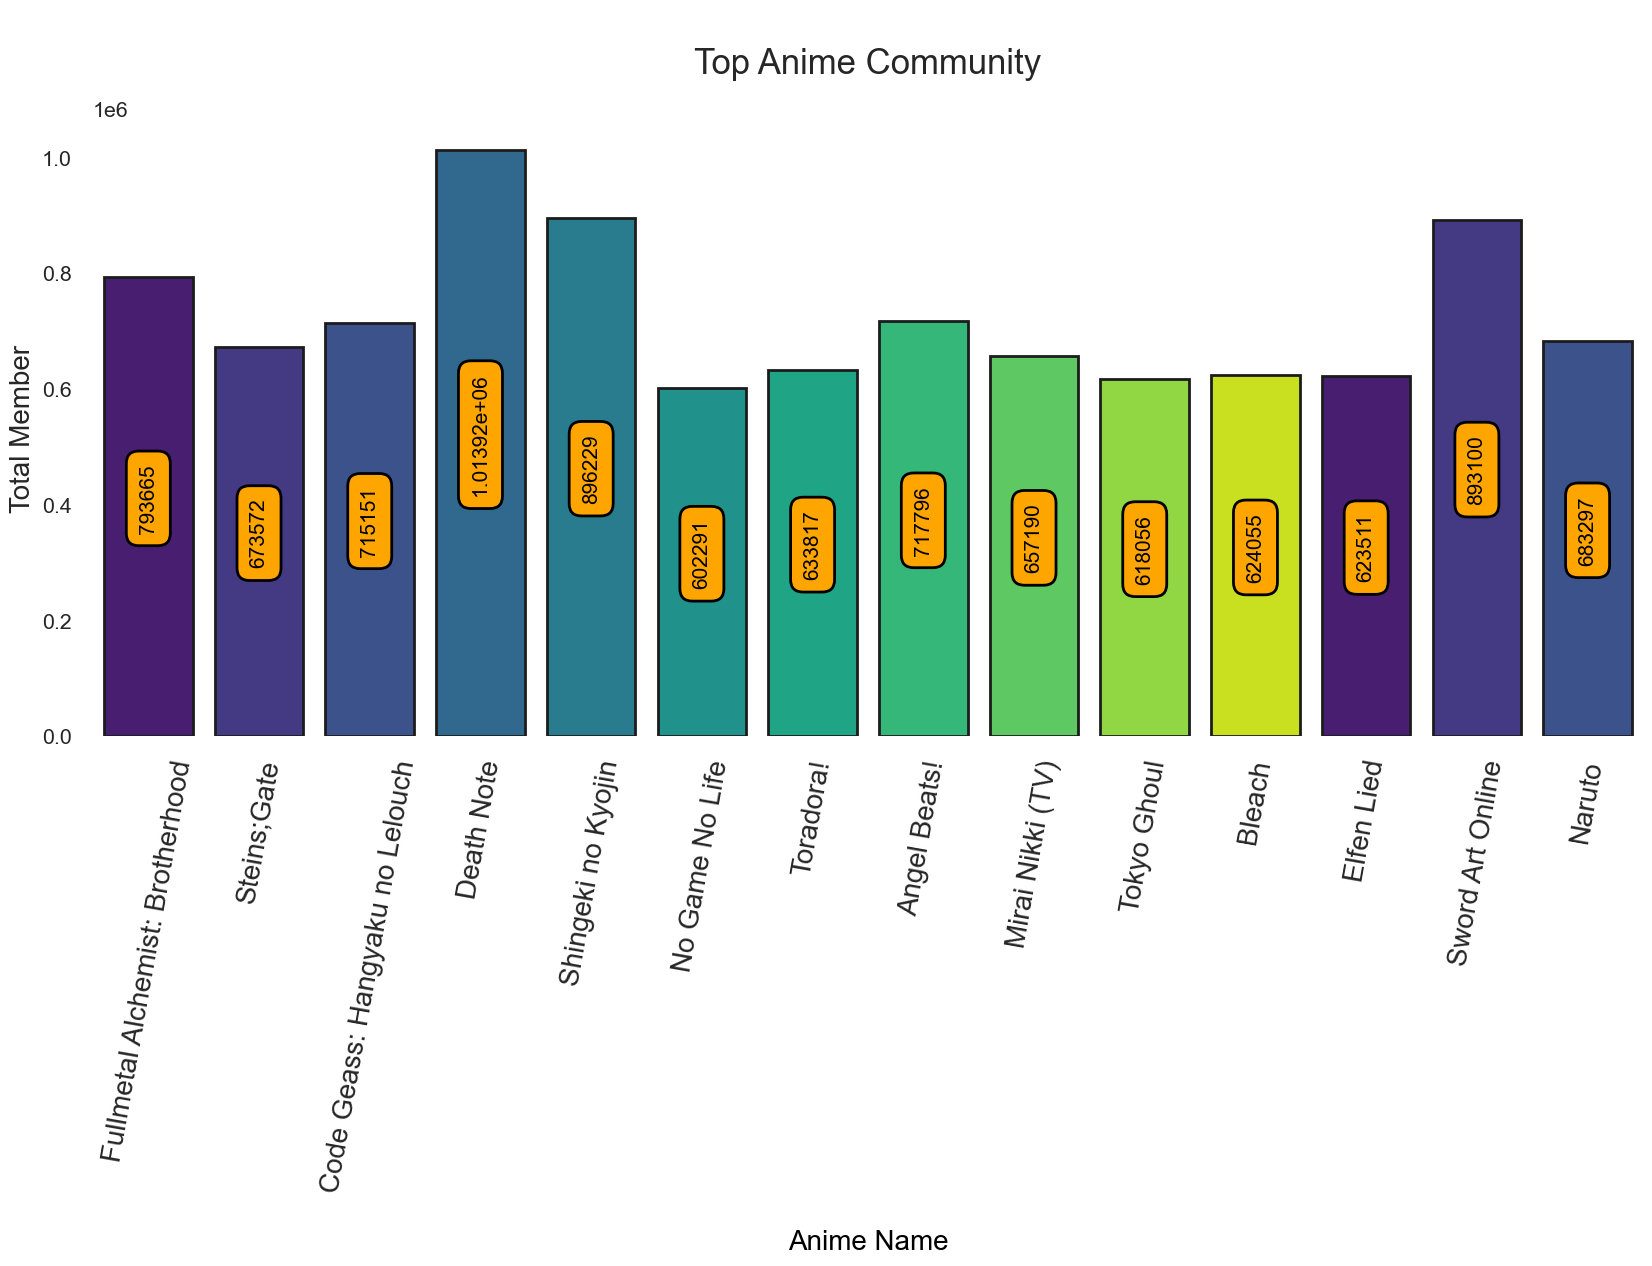

In [38]:
top_anime = anime_df.copy()
top_anime.drop_duplicates(subset ="name", keep = "first", inplace = True)
top_anime_temp1 = top_anime.sort_values(["members"],ascending=False)

plt.subplots(figsize=(20,8))
p = sns.barplot(x=top_anime_temp1["name"][:14],y=top_anime_temp1["members"],palette=palette, saturation=1, edgecolor = "#1c1c1c", linewidth = 2)
p.axes.set_title("\nTop Anime Community\n", fontsize=25)
plt.ylabel("Total Member" , fontsize = 20)
plt.xlabel("\nAnime Name" , fontsize = 20, color = "black")
# plt.yscale("log")
plt.xticks(rotation = 80, fontsize = 20)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 6,size = 15,color = "black",rotation = 90,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "orange", "edgecolor": "black", "alpha": 1})

sns.despine(left=True, bottom=True)
plt.show()

### Anime Category

In [39]:
print("Anime Categories :")
top_anime_temp1["type"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Anime Categories :


type,TV,OVA,Movie,Special,ONA,Music
count,3051,2725,1712,1443,474,444


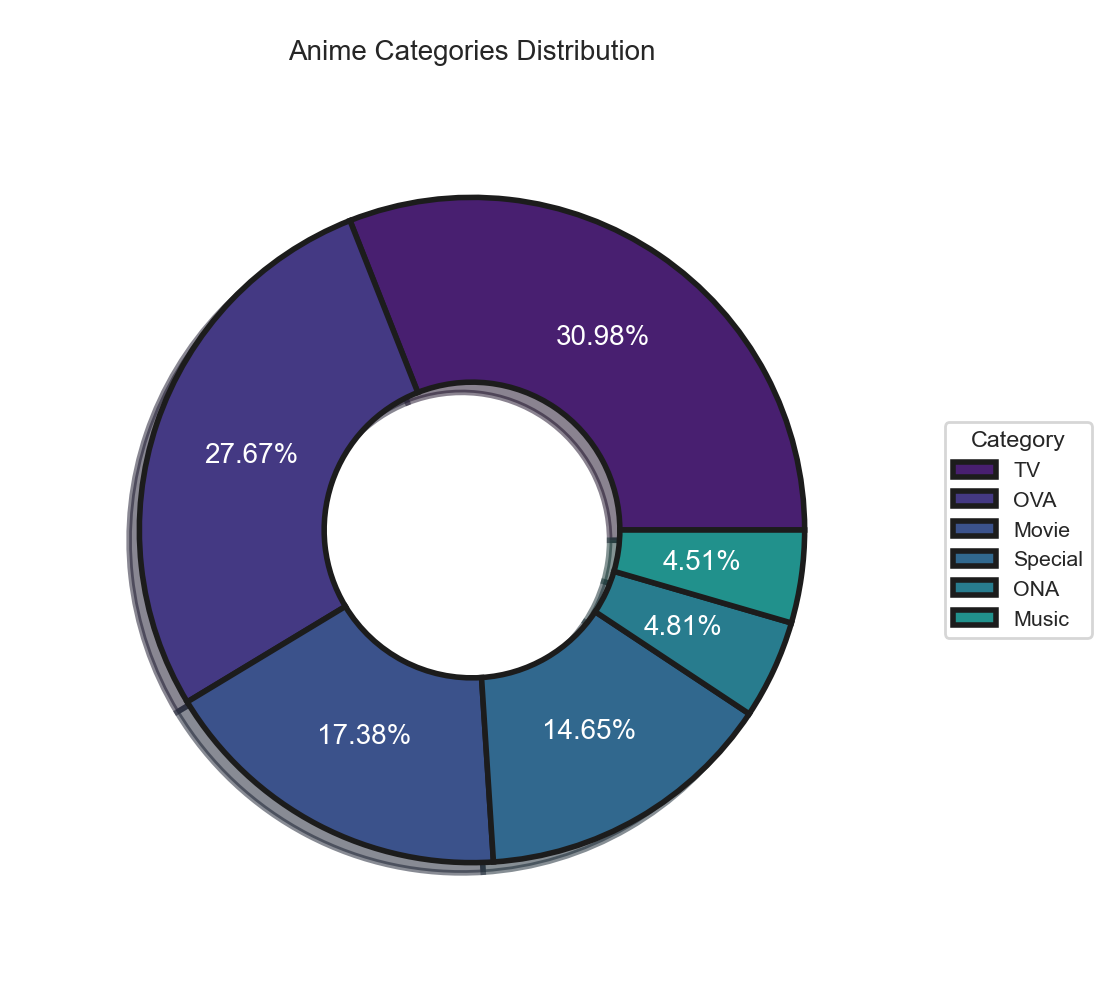

In [40]:
plt.subplots(figsize=(12, 12))

labels = "TV","OVA","Movie","Special","ONA","Music"
size = 0.5

wedges, texts, autotexts = plt.pie([len(top_anime_temp1[top_anime_temp1["type"]=="TV"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="OVA"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Movie"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Special"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="ONA"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Music"]["type"])],
                                    explode = (0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.7,
                                    radius=.9, 
                                    colors = palette, 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "#1c1c1c", 
                                    linewidth = 4),
                                    startangle = 0)

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nAnime Categories Distribution",fontsize=20)
plt.show()

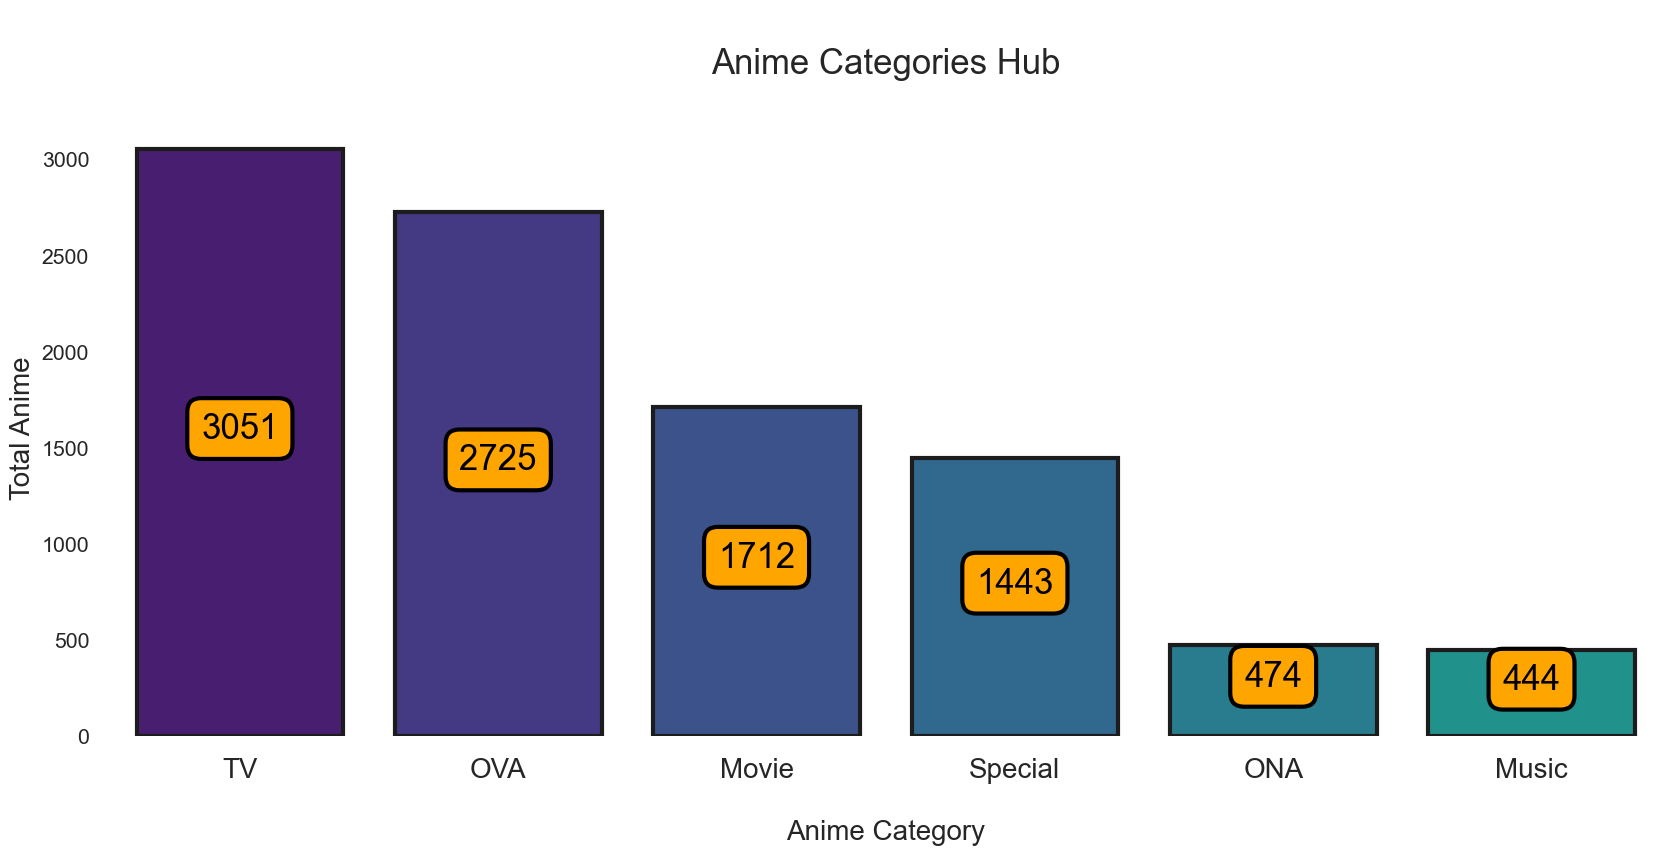

In [41]:
plt.subplots(figsize = (20,8))
p = sns.countplot(x = top_anime_temp1["type"], order = top_anime_temp1["type"].value_counts().index, palette = palette, saturation = 1, edgecolor = "#1c1c1c", linewidth = 3)
p.axes.set_title("\nAnime Categories Hub\n" ,fontsize = 25)
plt.ylabel("Total Anime" ,fontsize = 20)
plt.xlabel("\nAnime Category" ,fontsize = 20)
plt.xticks(rotation = 0, fontsize = 20)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 10,size = 25,color = "black",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "orange", "edgecolor": "black", "linewidth" : 3, "alpha": 1})

sns.despine(left = True, bottom = True)
plt.show()

### Overall Anime Ratings

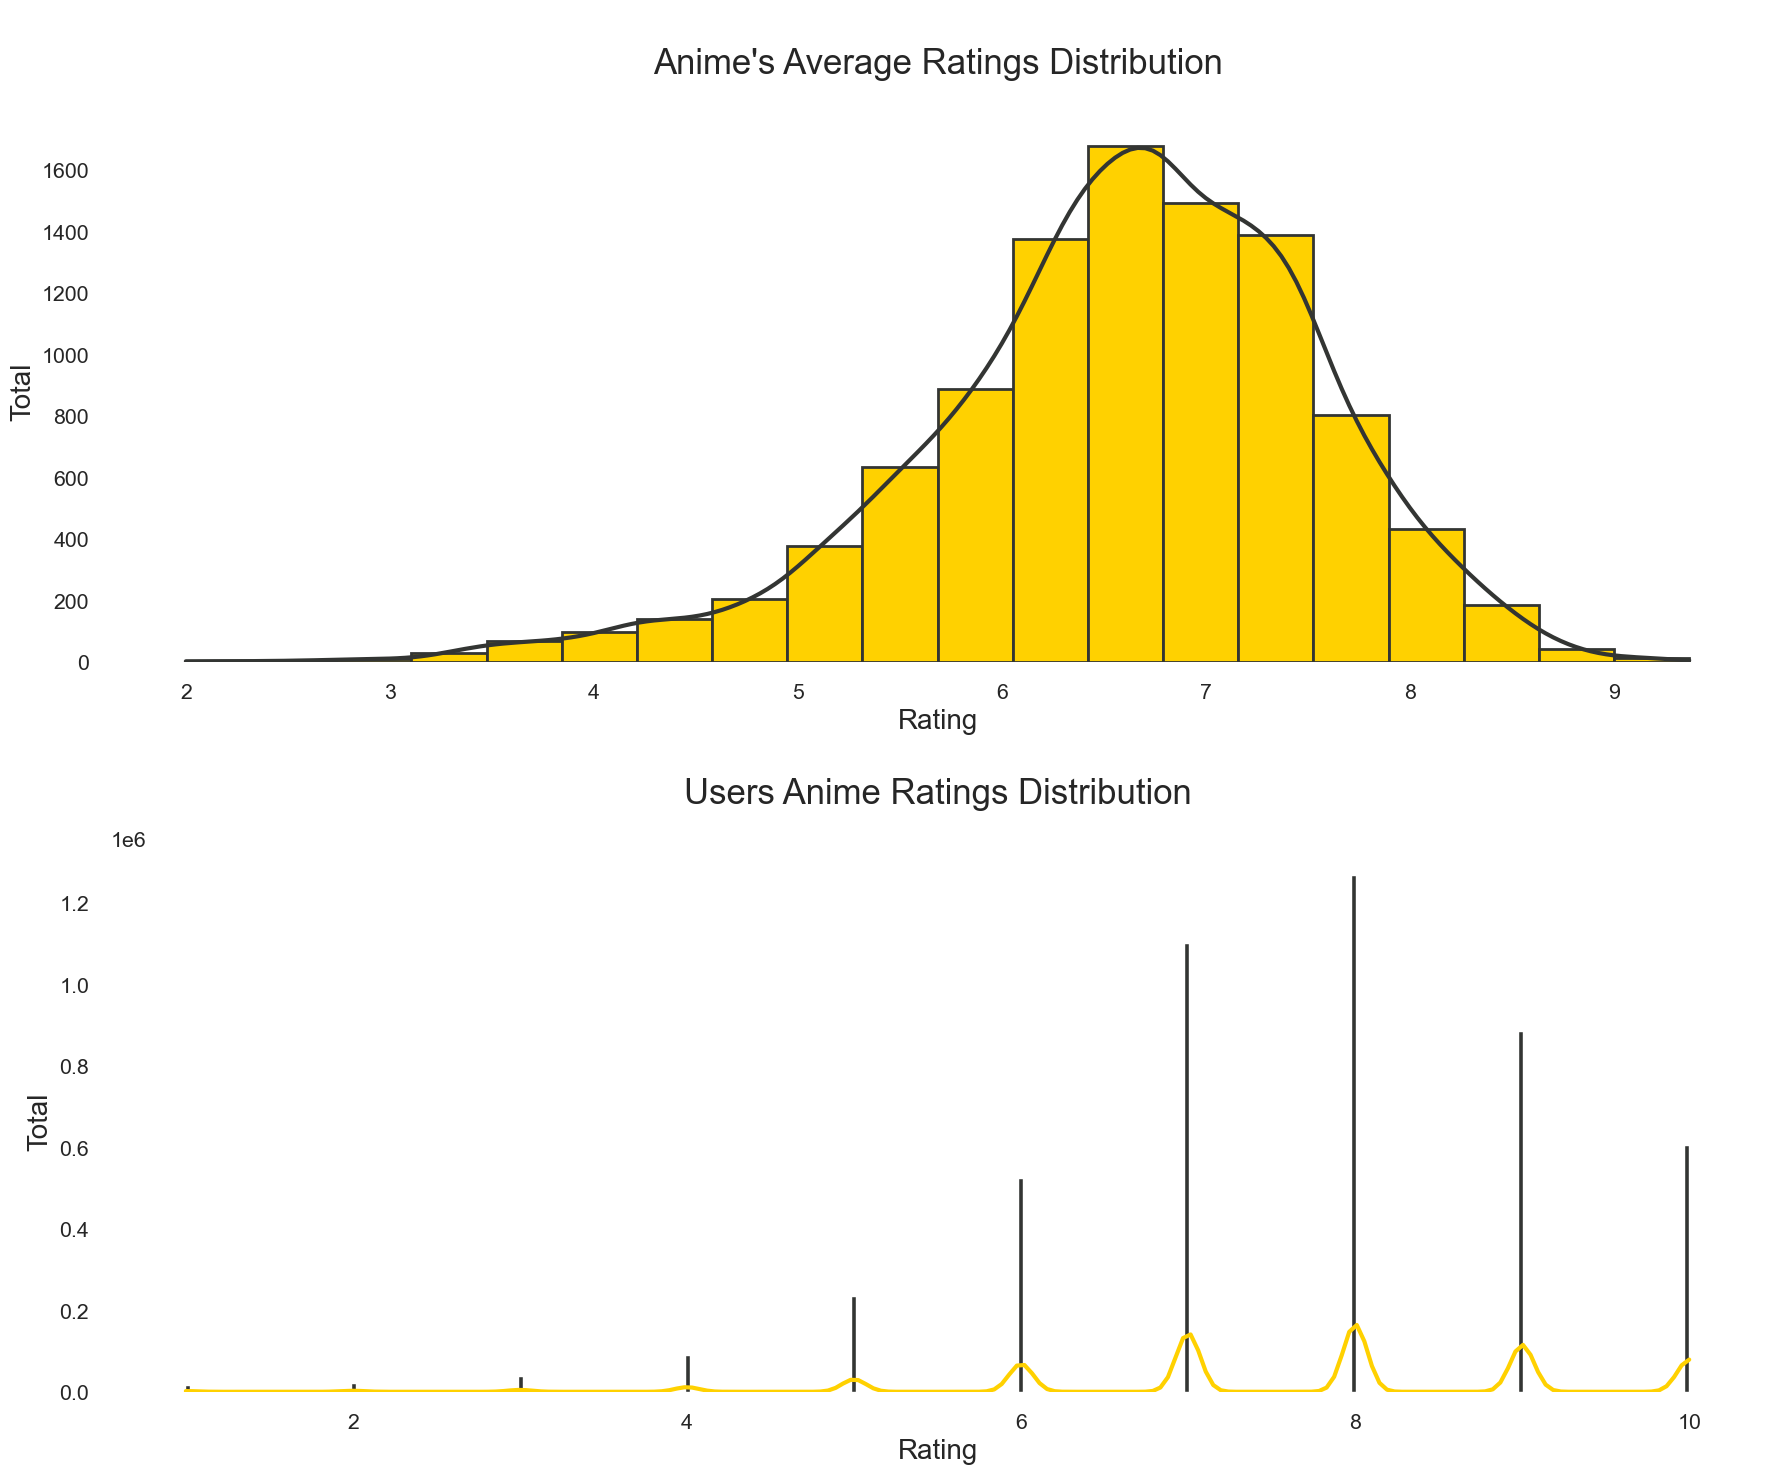

In [49]:
top_anime_temp2 = top_anime.sort_values(["rating"],ascending=False)

_, axs = plt.subplots(2,1,figsize=(20,16),sharex=False,sharey=False)
plt.tight_layout(pad=6.0)

sns.histplot(top_anime_temp2["rating"],color=palette[11],kde=True,ax=axs[0],bins=20,alpha=1,fill=True,edgecolor=palette[12])
axs[0].lines[0].set_color(palette[12])
axs[0].set_title("\nAnime's Average Ratings Distribution\n",fontsize = 25)
axs[0].set_xlabel("Rating\n", fontsize = 20)
axs[0].set_ylabel("Total", fontsize = 20)

sns.histplot(anime_rating["user_rating"],color=palette[12],kde=True,ax=axs[1],bins="auto",alpha=1,fill=True)
axs[1].lines[0].set_color(palette[11])
# axs[1].set_yscale("log")
axs[1].set_title("\n\n\nUsers Anime Ratings Distribution\n",fontsize = 25)
axs[1].set_xlabel("Rating", fontsize = 20)
axs[1].set_ylabel("Total", fontsize = 20)

sns.despine(left=True, bottom=True)
plt.show()

### Top Animes Based On Ratings

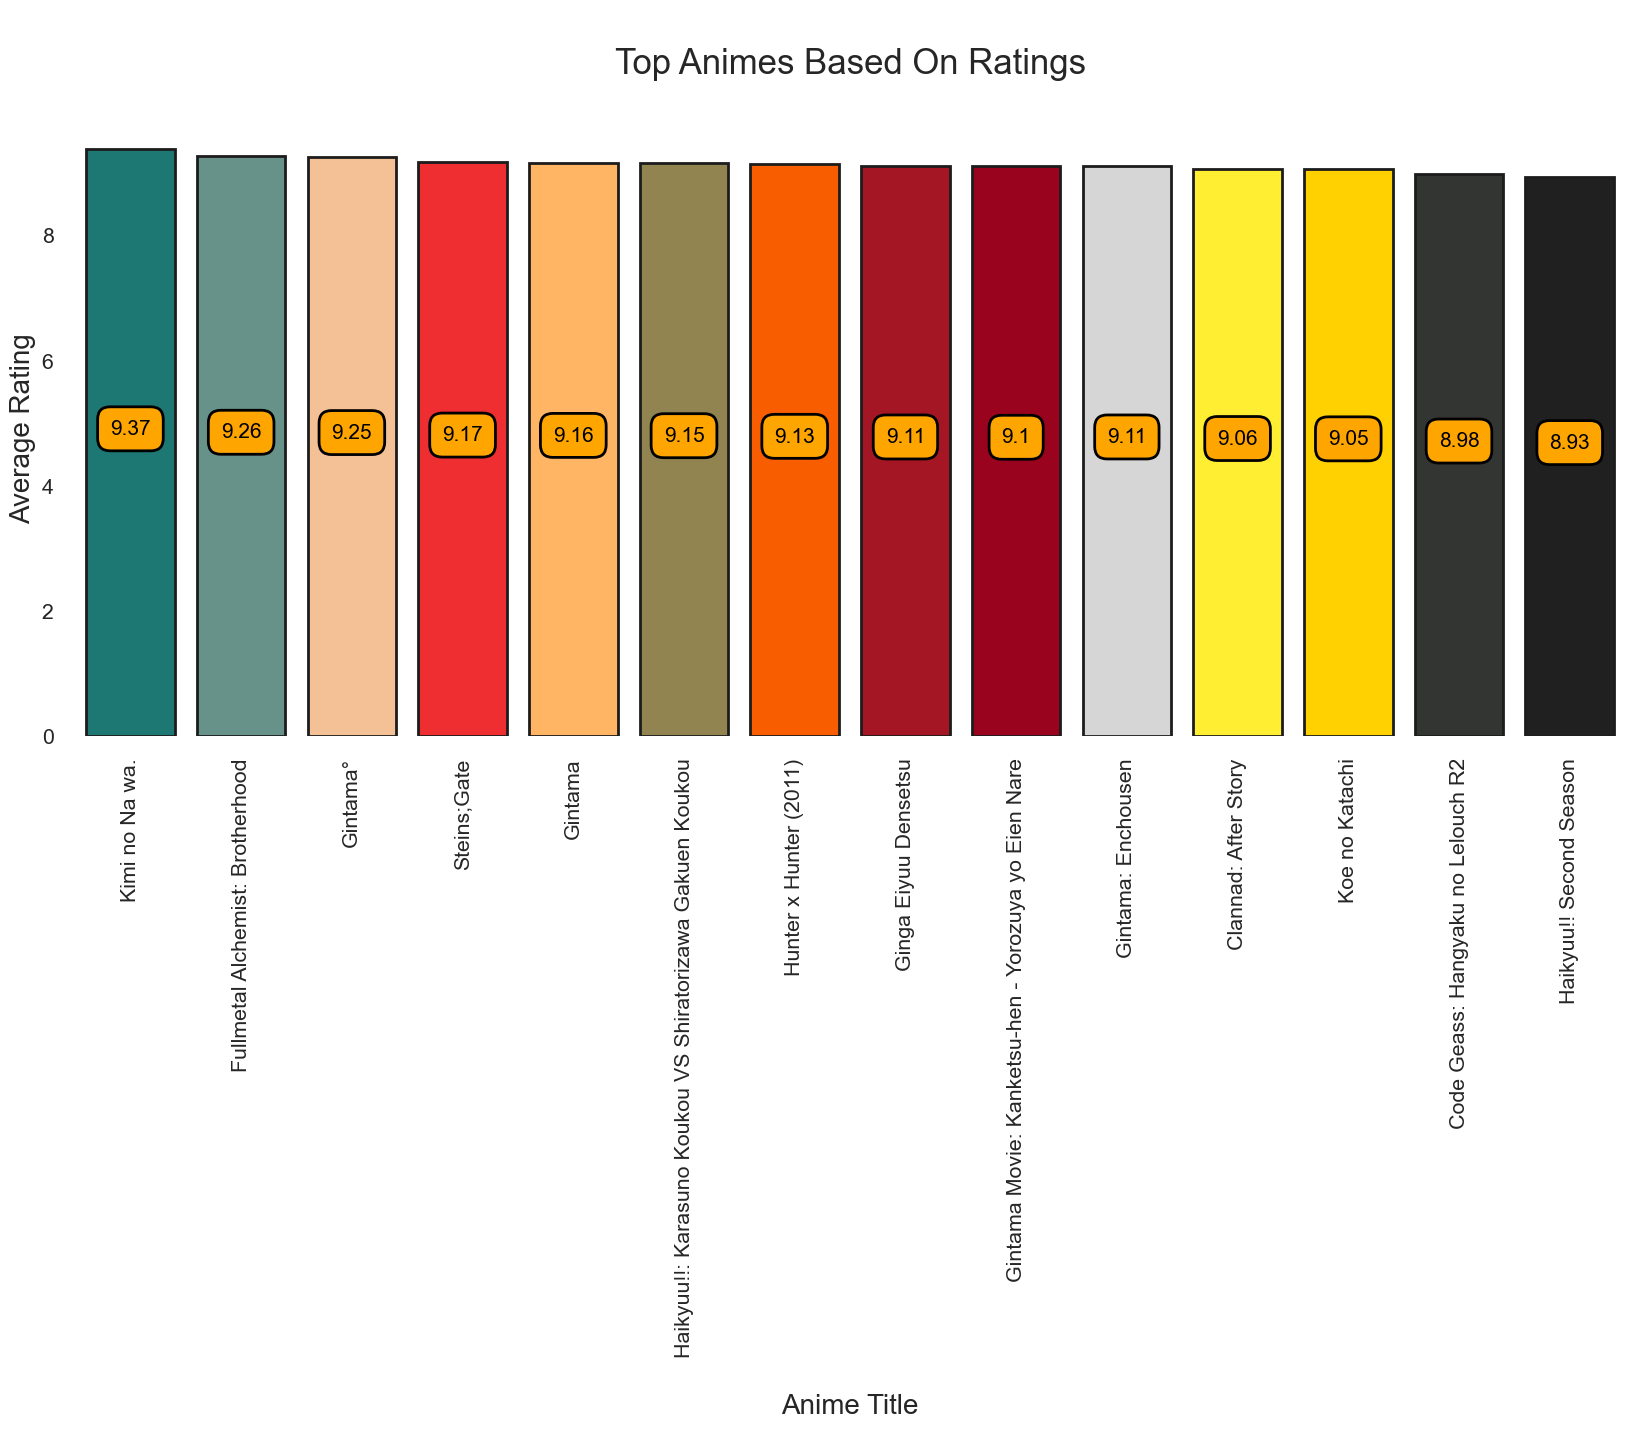

In [50]:
plt.subplots(figsize=(20,8))
p = sns.barplot(x=top_anime_temp2["name"][:14],y=top_anime_temp2["rating"],palette=palette, saturation=1, edgecolor = "#1c1c1c", linewidth = 2)
p.axes.set_title("\nTop Animes Based On Ratings\n",fontsize = 25)
plt.ylabel("Average Rating",fontsize = 20)
plt.xlabel("\nAnime Title",fontsize = 20)
# plt.yscale("log")
plt.xticks(rotation = 90)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 10,size = 15,color = "black",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "orange", "edgecolor": "black", "alpha": 1})

sns.despine(left=True, bottom=True)
plt.show()

### Category-wise Anime Ratings Distribution

Let's explore the ratings distribution of TV category :



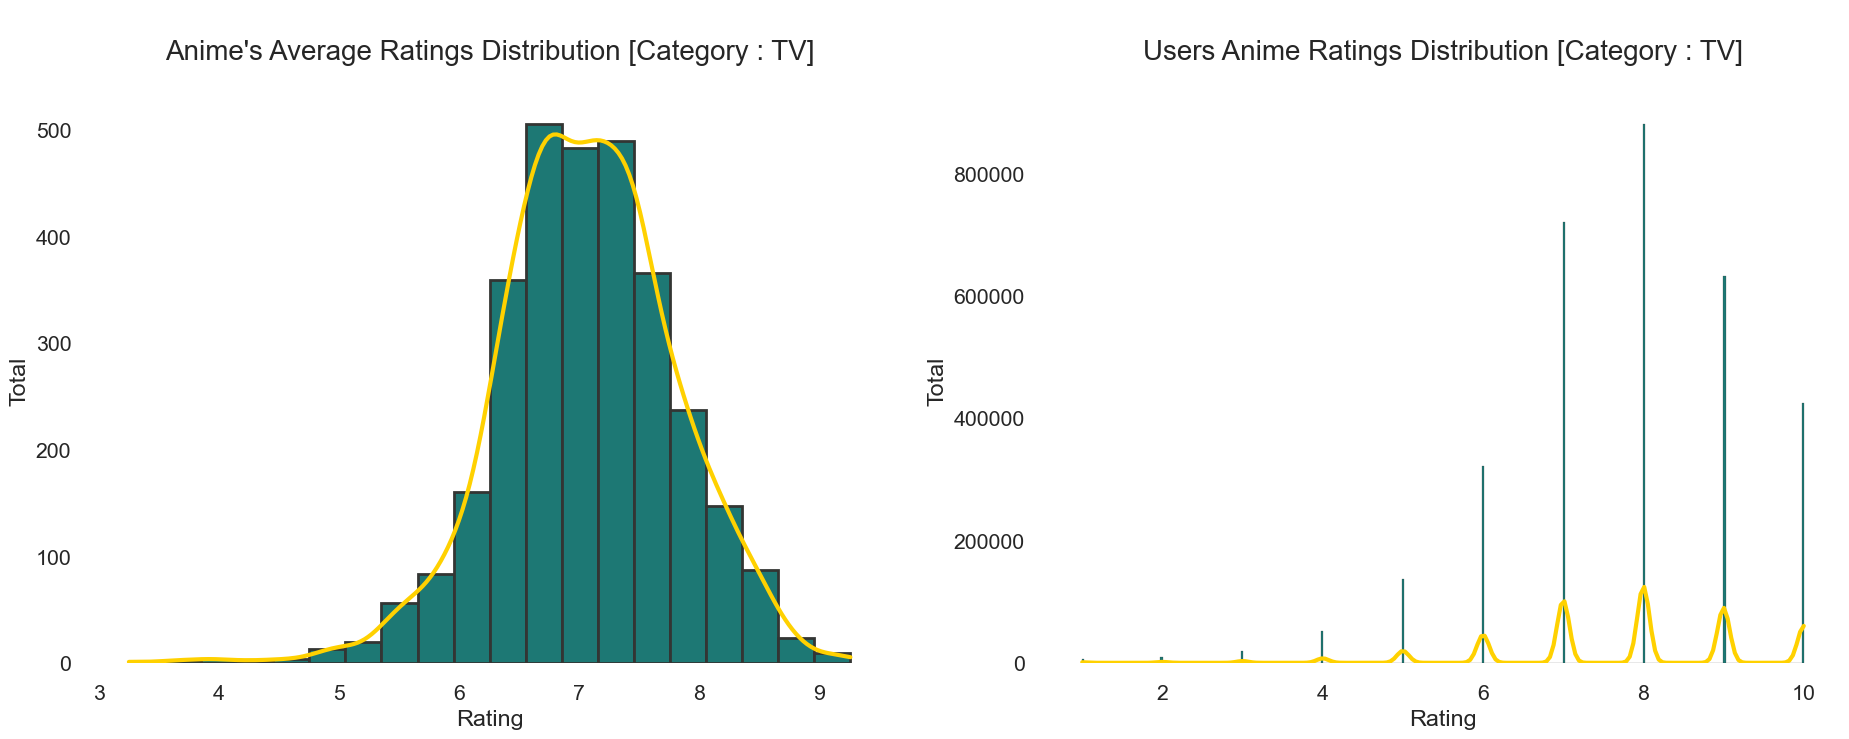

In [51]:
print("Let's explore the ratings distribution of TV category :\n")

_, axs = plt.subplots(1,2,figsize=(20,8),sharex=False,sharey=False)
plt.tight_layout(pad=4.0)

sns.histplot(top_anime_temp2[top_anime_temp2["type"]=="TV"]["rating"],color=palette[0],kde=True,ax=axs[0],bins=20,alpha=1,fill=True,edgecolor=palette[12])
axs[0].lines[0].set_color(palette[11])
axs[0].set_title("\nAnime's Average Ratings Distribution [Category : TV]\n",fontsize=20)
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("Total")

sns.histplot(anime_df[anime_df["type"]=="TV"]["user_rating"],color=palette[0],kde=True,ax=axs[1],bins="auto",alpha=1,fill=True,edgecolor=palette[12])
axs[1].lines[0].set_color(palette[11])
# axs[1].set_yscale("log")
axs[1].set_title("\nUsers Anime Ratings Distribution [Category : TV]\n",fontsize=20)
axs[1].set_xlabel("Rating")
axs[1].set_ylabel("Total")

sns.despine(left=True, bottom=True)
plt.show()

Let's explore the ratings distribution of MOVIE category :



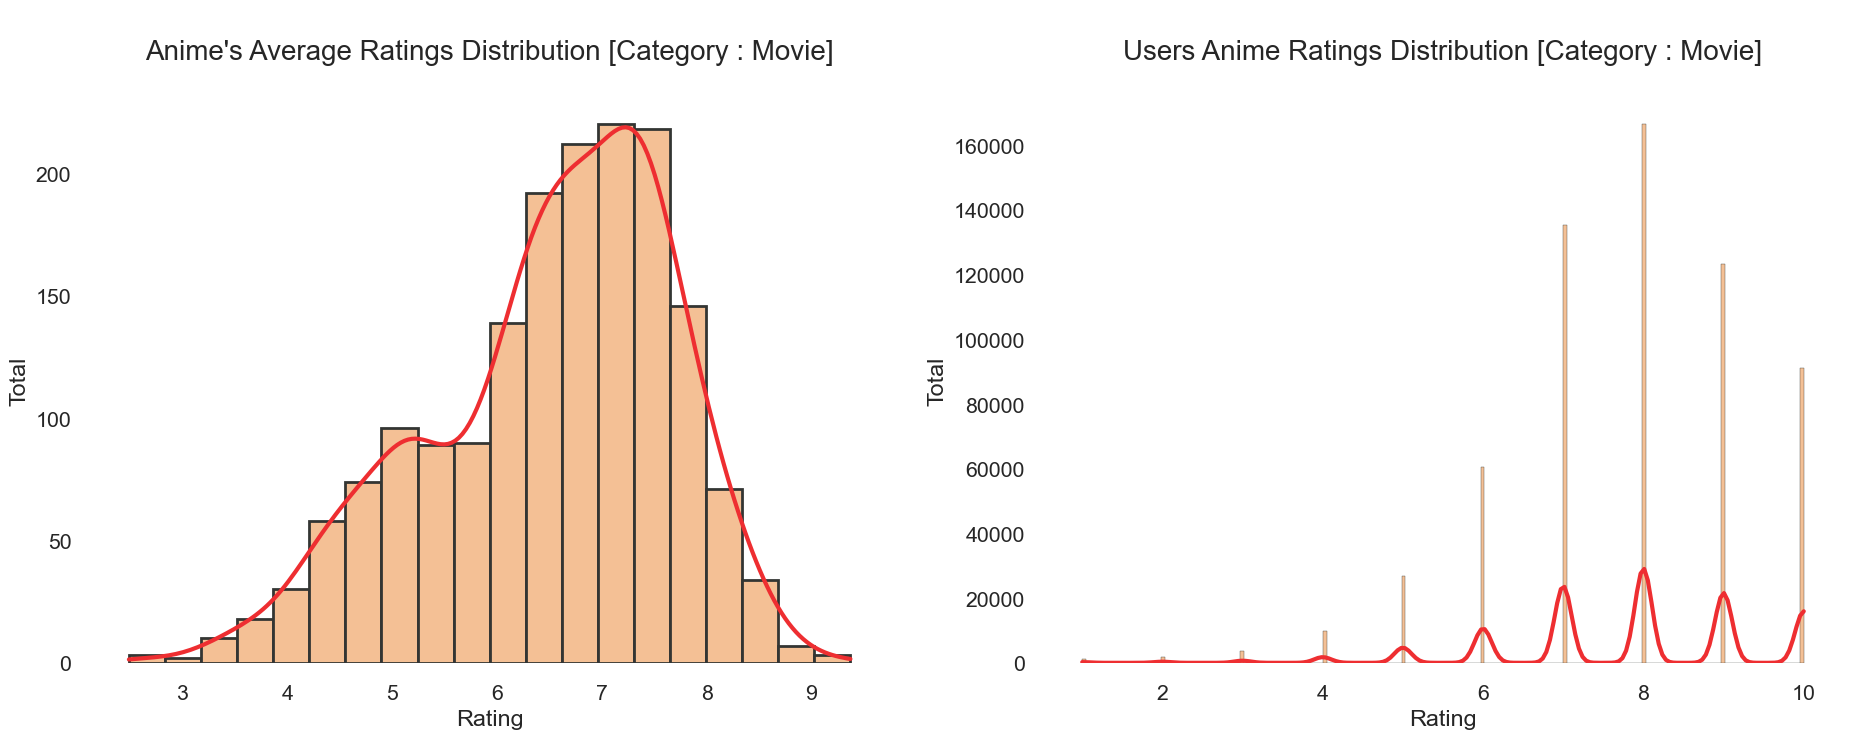

In [52]:
print("Let's explore the ratings distribution of MOVIE category :\n")

_, axs = plt.subplots(1,2,figsize=(20,8),sharex=False,sharey=False)
plt.tight_layout(pad=4.0)

sns.histplot(top_anime_temp2[top_anime_temp2["type"]=="Movie"]["rating"],color=palette[2],kde=True,ax=axs[0],bins=20,alpha=1,fill=True,edgecolor=palette[12])
axs[0].lines[0].set_color(palette[3])
axs[0].set_title("\nAnime's Average Ratings Distribution [Category : Movie]\n",fontsize=20)
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("Total")

sns.histplot(anime_df[anime_df["type"]=="Movie"]["user_rating"],color=palette[2],kde=True,ax=axs[1],bins="auto",alpha=1,fill=True,edgecolor=palette[12])
axs[1].lines[0].set_color(palette[3])
# axs[1].set_yscale("log")
axs[1].set_title("\nUsers Anime Ratings Distribution [Category : Movie]\n",fontsize=20)
axs[1].set_xlabel("Rating")
axs[1].set_ylabel("Total")

sns.despine(left=True, bottom=True)
plt.show()

# **Demographic Filtering**

#### Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

### where

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

In [53]:
anime_df = anime_rating.copy()

In [54]:
anime_df = process_anime_ratings(anime_df)

print(anime_df.shape)
anime_df.head(2)

(9854, 9)


,anime_id,name,genre,type,episodes,rating,members,vote_average,vote_count
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,9.40,1425
1425,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,9.28,11292


In [55]:
C= anime_df['vote_average'].mean()
print(f'Mean vote across the whole report: {C}')

# vote_averages = anime_df[anime_df['vote_average'].notnull()]['vote_average'].astype('int')
# C = vote_averages.mean()

m= anime_df['vote_count'].quantile(0.85)
print(f'Minimum votes required to be listed in the chart: {m}')

# # vote_counts = anime_df[anime_df['vote_count'].notnull()]['vote_count'].astype('int')
# m = vote_counts.quantile(0.95)

Mean vote across the whole report: 6.587537040795616
Minimum votes required to be listed in the chart: 820.0499999999993


In [56]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [57]:
qualified = anime_df[(anime_df['vote_count'] >= m) & (anime_df['vote_count'].notnull()) & (anime_df['vote_average'].notnull())][['name', 'genre', 'type', 'episodes', 'rating', 'members','vote_average', 'vote_count']]
print(f'shape of the filtered dataframe: {qualified.shape}')

shape of the filtered dataframe: (1478, 8)


In [58]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
qualified['wr_score'] = qualified.apply(weighted_rating, axis=1)

In [59]:
#Sort movies based on score calculated above
qualified = qualified.sort_values('wr_score', ascending=False).head(250)

### Top Anime

In [60]:
qualified.head(15)

,name,genre,type,episodes,rating,members,vote_average,vote_count,wr_score
1425,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,9.28,11292,9.097706
13736,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572,9.24,10446,9.046929
36361,Clannad: After Story,"[Drama, Fantasy, Romance, Slice of Life, Super...",TV,24,9.06,456749,9.12,9279,8.914362
48757,Code Geass: Hangyaku no Lelouch R2,"[Action, Drama, Mecha, Military, Sci-Fi, Super...",TV,25,8.98,572888,9.00,12006,8.845756
27486,Hunter x Hunter (2011),"[Action, Adventure, Shounen, Super Power]",TV,148,9.13,425855,9.20,4709,8.812528
84917,Code Geass: Hangyaku no Lelouch,"[Action, Mecha, Military, School, Sci-Fi, Supe...",TV,25,8.83,715151,8.89,13042,8.753791
143354,Tengen Toppa Gurren Lagann,"[Action, Adventure, Comedy, Mecha, Sci-Fi]",TV,27,8.78,562962,8.88,10094,8.707751
111627,One Punch Man,"[Action, Comedy, Parody, Sci-Fi, Seinen, Super...",TV,12,8.82,552458,8.91,7798,8.689006
45671,Gintama,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,201,9.04,336376,9.20,3086,8.651530
73268,Shigatsu wa Kimi no Uso,"[Drama, Music, Romance, School, Shounen]",TV,22,8.92,416397,8.92,5899,8.635326


### deponed of the genres on the score

In [61]:
s = anime_df.explode('genre')[['genre']]
s['genre'] = s['genre'].str.title()
gen_df = anime_df.drop('genre', axis=1).join(s)

print(f'Shape of the genres dataframe: {gen_df.shape}')


Shape of the genres dataframe: (30732, 9)


In [62]:
def build_chart(genre, percentile=0.85):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count']
    vote_averages = df[df['vote_average'].notnull()]['vote_average']
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['name', 'genre', 'type', 'episodes', 'rating', 'members','vote_average', 'vote_count']]
    qualified['vote_count'] = qualified['vote_count']
    qualified['vote_average'] = qualified['vote_average']
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [63]:
genre_list = gen_df['genre'].value_counts().index.to_list()

print(genre_list)

['Comedy', 'Action', 'Adventure', 'Sci-Fi', 'Fantasy', 'Drama', 'Shounen', 'Romance', 'School', 'Hentai', 'Slice Of Life', 'Supernatural', 'Mecha', 'Kids', 'Music', 'Magic', 'Ecchi', 'Historical', 'Shoujo', 'Seinen', 'Mystery', 'Sports', 'Super Power', 'Military', 'Space', 'Parody', 'Horror', 'Harem', 'Demons', 'Martial Arts', 'Psychological', 'Dementia', 'Police', 'Game', 'Samurai', 'Vampire', 'Thriller', 'Shounen Ai', 'Shoujo Ai', 'Cars', 'Josei', 'Yuri', 'Yaoi']


### Top Romance Movies

In [64]:
build_chart('Comedy').head(10)

,name,genre,type,episodes,rating,members,vote_average,vote_count,wr
143354,Tengen Toppa Gurren Lagann,Comedy,TV,27,8.78,562962,8.88,10094,8.663237
111627,One Punch Man,Comedy,TV,12,8.82,552458,8.91,7798,8.633951
126987,Suzumiya Haruhi no Shoushitsu,Comedy,Movie,1,8.81,240297,8.89,5945,8.545817
45671,Gintama,Comedy,TV,201,9.04,336376,9.20,3086,8.539445
153448,Great Teacher Onizuka,Comedy,TV,43,8.77,268487,8.85,5663,8.498723
104150,Cowboy Bebop,Comedy,TV,26,8.82,486824,8.75,7477,8.486001
24182,Gintama,Comedy,TV,51,9.16,151266,9.25,2397,8.446441
432375,No Game No Life,Comedy,TV,12,8.47,602291,8.58,9872,8.391600
479531,Toradora!,Comedy,TV,25,8.45,633817,8.53,12457,8.381659
132932,Monogatari Series: Second Season,Comedy,TV,26,8.80,205959,8.81,4232,8.375199


### Top Action Movies

In [65]:
build_chart('Action').head(10)

,name,genre,type,episodes,rating,members,vote_average,vote_count,wr
1425,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665,9.28,11292,8.993953
48757,Code Geass: Hangyaku no Lelouch R2,Action,TV,25,8.98,572888,9.00,12006,8.761071
84917,Code Geass: Hangyaku no Lelouch,Action,TV,25,8.83,715151,8.89,13042,8.679730
27486,Hunter x Hunter (2011),Action,TV,148,9.13,425855,9.20,4709,8.633031
143354,Tengen Toppa Gurren Lagann,Action,TV,27,8.78,562962,8.88,10094,8.617837
111627,One Punch Man,Action,TV,12,8.82,552458,8.91,7798,8.578481
171751,Fate/Zero 2nd Season,Action,TV,12,8.73,340973,8.82,7367,8.488122
315145,Shingeki no Kyojin,Action,TV,25,8.54,896229,8.65,12561,8.458958
45671,Gintama,Action,TV,201,9.04,336376,9.20,3086,8.434633
104150,Cowboy Bebop,Action,TV,26,8.82,486824,8.75,7477,8.434199


# **Content Based Filtering**

In [66]:
smd_1 = anime_rating.copy()

In [67]:
smd_1 = process_anime_ratings(smd_1)

print(smd_1.shape)
smd_1.head(2)

(9854, 9)


,anime_id,name,genre,type,episodes,rating,members,vote_average,vote_count
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,9.40,1425
1425,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,9.28,11292


## Using genre for **Content Based Filtering**

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents="unicode", analyzer="word",
                      token_pattern=r"\w{1,}", ngram_range=(1, 3), stop_words = "english")

rec_data = smd_1.copy()
rec_data.drop_duplicates(subset ="name", keep = "first", inplace = True)
rec_data.reset_index(drop = True, inplace = True)
genres = rec_data["genre"].apply(lambda x: ", ".join(map(str, x)) if isinstance(x, list) else "").astype(str)
tfv_matrix = tfv.fit_transform(genres)

In [69]:
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)      # Computing sigmoid kernel
# sig = cosine_similarity(tfidf_matrix, tfidf_matrix)
# sig = linear_kernel(tfidf_matrix, tfidf_matrix)

rec_indices = pd.Series(rec_data.index, index = rec_data["name"]).drop_duplicates()

In [70]:
# Recommendation Function
def give_recommendation(title, sig = sig):
    
    idx = rec_indices[title] # Getting index corresponding to original_title

    sig_score = list(enumerate(sig[idx]))  # Getting pairwsie similarity scores 
    sig_score = sorted(sig_score, key=lambda x: x[1], reverse=True)
    sig_score = sig_score[1:11]
    anime_indices = [i[0] for i in sig_score]
     
    # Top 10 most similar movies
    rec_dic = {"No" : range(1,11), 
               "Anime Name" : anime["name"].iloc[anime_indices].values,
               "Rating" : anime["rating"].iloc[anime_indices].values}
    dataframe = pd.DataFrame(data = rec_dic)
    dataframe.set_index("No", inplace = True)
    
    print(f"Recommendations for {title} viewers :\n")
    
    return dataframe.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

In [71]:
give_recommendation("Naruto")

Recommendations for Naruto viewers :



,Anime Name,Rating
No,,
1,To LOVE-Ru Darkness,7.820000
2,Initial D: Project D to the Next Stage - Project D e Mukete,7.690000
3,Mugen no Ryvius,7.590000
4,Future GPX Cyber Formula,7.540000
5,Shin Chou Kyou Ryo: Condor Hero II,7.510000
6,Toriko Movie: Bishokushin no Special Menu,7.270000
7,Kyojin no Hoshi,7.120000
8,Ganso Banana no Tamashii,5.130000
9,Mirakururun Grand Purin!,5.370000


In [72]:
give_recommendation("Death Note")

Recommendations for Death Note viewers :



,Anime Name,Rating
No,,
1,Hachimitsu to Clover Specials,7.850000
2,The iDOLM@STER,7.750000
3,Major S1,8.420000
4,Kore wa Zombie Desu ka? OVA,7.570000
5,Rui no Masaiban,4.890000
6,Gin no Saji,8.180000
7,"Shin Kimagure Orange☆Road: Soshite, Ano Natsu no Hajimari",7.630000
8,Ou Dorobou Jing in Seventh Heaven,7.430000
9,Fate/Zero 2nd Season,8.730000


## Using only Numerical column for **Content Based Filtering**

In [73]:
ndf = smd_1.select_dtypes(include=["float64","int64","float32","int32"])

ndf.drop(columns=['anime_id'], inplace=True)

print(f'ndf shape is: {ndf.shape}')

ndf.head()

ndf shape is: (9854, 5)


,episodes,rating,members,vote_average,vote_count
0,1,9.37,200630,9.40,1425
1425,64,9.26,793665,9.28,11292
12717,51,9.25,114262,9.42,1019
13736,24,9.17,673572,9.24,10446
24182,51,9.16,151266,9.25,2397


In [74]:
# Create MinMaxScaler Object
scaler = MinMaxScaler(feature_range=(0, 1))

# Create dataframe after transformation
ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))

# assign column names
ndfmx.columns=ndf.columns

# Show initial 5 records
ndfmx.head()


,episodes,rating,members,vote_average,vote_count
0,0.000000,1.000000,0.197850,0.933333,0.098207
1,0.034673,0.985075,0.782764,0.920000,0.778690
2,0.027518,0.983718,0.112665,0.935556,0.070207
3,0.012658,0.972863,0.664316,0.915556,0.720345
4,0.027518,0.971506,0.149162,0.916667,0.165241


### **Cosine similarity**

### $cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [75]:
# Compute the cosine similarity
cosine_sim_1 = cosine_similarity(ndfmx, ndfmx)

cosine_sim_1.shape

(9854, 9854)

In [76]:
# Reverse mapping of indices and movie titles
indices = pd.Series(smd_1.index, index=smd_1['name']).drop_duplicates()

print(f'Indices shape is: {indices.shape}')
indices.head()

Indices shape is: (9854,)


name
Kimi no Na wa.                          0
Fullmetal Alchemist: Brotherhood     1425
Gintama°                            12717
Steins;Gate                         13736
Gintama                             24182
dtype: int64

In [77]:
smd_1 = smd_1.reset_index()
titles = smd_1['name']
indices = pd.Series(smd_1.index, index=smd_1['name'])

In [78]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim, recommendations_num=10):
    
    recommendations_num = recommendations_num + 1
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:recommendations_num]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

In [79]:
get_recommendations('Kimi no Na wa.', cosine_sim_1)

604                                91 Days
877                                 Orange
2152                            Kiss x Sis
41      Ansatsu Kyoushitsu (TV) 2nd Season
106                              Shirobako
841                  Angel Beats! Specials
49                  Yojouhan Shinwa Taikei
1272               Tales of Zestiria the X
862                                   Ajin
170           Kuroshitsuji: Book of Circus
Name: name, dtype: object

In [80]:
def improved_recommendations(title, cosine_sim, recommendations_num=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd_1.iloc[movie_indices][['name', 'genre', 'type', 'episodes', 'rating', 'members','vote_average', 'vote_count']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count']
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average']
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified = qualified.copy()
    qualified['vote_count'] = qualified['vote_count']
    qualified['vote_average'] = qualified['vote_average']
    qualified['wr_score'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr_score', ascending=False).head(recommendations_num)
    return qualified

In [81]:
improved_recommendations('Kimi no Na wa.', cosine_sim_1)

,name,genre,type,episodes,rating,members,vote_average,vote_count,wr_score
52,Rainbow: Nisha Rokubou no Shichinin,"[Drama, Historical, Seinen, Thriller]",TV,26,8.64,139474,8.78,2098,8.163859
41,Ansatsu Kyoushitsu (TV) 2nd Season,"[Action, Comedy, School, Shounen]",TV,25,8.68,176475,8.64,2021,8.047570
106,Shirobako,"[Comedy, Drama]",TV,24,8.49,146895,8.60,1860,7.984220
130,Owarimonogatari,"[Comedy, Mystery, Supernatural]",TV,12,8.43,107855,8.45,1705,7.845136
170,Kuroshitsuji: Book of Circus,"[Comedy, Demons, Fantasy, Historical, Shounen,...",TV,10,8.37,122895,8.28,1807,7.751687
266,Durarara!!x2 Ketsu,"[Action, Mystery, Supernatural]",TV,12,8.23,115295,8.24,1676,7.697101
862,Ajin,"[Action, Horror, Mystery, Seinen, Supernatural]",TV,13,7.78,160972,7.86,1914,7.478338
680,Noragami OVA,"[Action, Adventure, Shounen]",OVA,2,7.89,104775,7.80,1753,7.413579
841,Angel Beats! Specials,"[Action, Comedy, School, Supernatural]",Special,2,7.79,139013,7.80,1750,7.413128
1102,Sakamoto desu ga?,"[Comedy, School, Seinen]",TV,12,7.67,171452,7.70,1927,7.367907


# **Collaborative Filtering**

In [82]:
anime_coll = anime_rating.copy()

In [83]:
anime_coll = process_anime_ratings(anime_coll)

print(anime_coll.shape)
anime_coll.head(2)

(9854, 9)


,anime_id,name,genre,type,episodes,rating,members,vote_average,vote_count
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,9.40,1425
1425,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,9.28,11292


In [84]:
# Define the reader
reader = Reader()

# Create the dataset
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

# Perform K-fold cross-validation
kf = KFold(n_splits=5)
svd = SVD()

# for trainset, testset in kf.split(data):
#     svd.fit(trainset)
#     predictions = svd.test(testset)
#     # Process predictions if needed

# Alternatively, use cross_validate for a higher-level API
results = cross_validate(svd, data,  measures=['RMSE', 'MAE'], cv=5, verbose=True)

results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.1111  3.1078  3.1080  3.1088  3.1116  3.1095  0.0016  
MAE (testset)     2.7981  2.7940  2.7947  2.7957  2.7985  2.7962  0.0018  
Fit time          24.28   23.95   23.54   22.83   22.70   23.46   0.62    
Test time         5.24    3.91    4.46    5.09    5.11    4.76    0.51    


{'test_rmse': array([3.1111142 , 3.10784927, 3.10795194, 3.1087514 , 3.11162554]),
 'test_mae': array([2.79806835, 2.79398353, 2.79472512, 2.79567865, 2.79845128]),
 'fit_time': (24.284646034240723,
  23.95169734954834,
  23.539759159088135,
  22.827704906463623,
  22.702752590179443),
 'test_time': (5.241485834121704,
  3.90712833404541,
  4.460164308547974,
  5.09454345703125,
  5.112349510192871)}

In [85]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [86]:
rating[rating['user_id'] == 7]

,user_id,anime_id,rating
806,7,22,7.0
807,7,30,10.0
808,7,31,9.0
809,7,32,9.0
810,7,59,7.0
...,...,...,...
1144,7,32360,7.0
1145,7,32380,4.0
1146,7,32553,5.0
1147,7,33091,8.0


In [87]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=5, details={'was_impossible': False})

In [88]:
def collaborative_filtering_svd(
    user_id, n_recommendations=10, svd_model=svd, ratings_df=rating, movies_df=anime_coll
):
    # Merge datasets to link movieId with TMDb metadata
    merged_df = ratings_df.copy()
    merged_df = merged_df.merge(movies_df[["anime_id", "name", "genre", "type", "rating", "vote_average", "vote_count"]], 
                                left_on="anime_id", right_on="anime_id", how="left")
    
    # Get the list of movies the user has already watched
    watched_movies = ratings_df[ratings_df["user_id"] == user_id]["anime_id"].tolist()
    
    # Get all unique movie IDs
    movie_ids = ratings_df["anime_id"].unique()
    
    # Predict ratings for all movies the user hasn't watched
    predictions = [
        svd_model.predict(user_id, movie_id) for movie_id in movie_ids if movie_id not in watched_movies
    ]
    
    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N recommendations
    top_movie_ids = [pred.iid for pred in predictions[:n_recommendations]]
    
    # Retrieve movie details
    recommended_movies = merged_df[merged_df["anime_id"].isin(top_movie_ids)].drop_duplicates(subset="anime_id")
    
    # Prepare the result DataFrame
    result = recommended_movies[["name", "genre", "type", "vote_average", "vote_count"]].copy()
    result["predicted_rating"] = [pred.est for pred in predictions[:n_recommendations]]
    result = result.sort_values(by="predicted_rating", ascending=False).head(n_recommendations)
    
    return result


In [89]:
# Get recommendations
user_recommendations = collaborative_filtering_svd(1)
user_recommendations

,name,genre,type,vote_average,vote_count,predicted_rating
0,Trigun,"[Action, Comedy, Sci-Fi]",TV,8.32,5774.0,5
1,Eyeshield 21,"[Action, Comedy, Shounen, Sports]",TV,8.23,1505.0,5
2,Hungry Heart: Wild Striker,"[Comedy, Shounen, Slice of Life, Sports]",TV,7.90,392.0,5
3,Initial D Fourth Stage,"[Action, Cars, Drama, Seinen, Sports]",TV,8.25,1152.0,5
4,Naruto,"[Action, Comedy, Martial Arts, Shounen, Super ...",TV,7.66,10287.0,5
5,Prince of Tennis,"[Action, Comedy, School, Shounen, Sports]",TV,8.06,1512.0,5
6,School Rumble,"[Comedy, Romance, School, Shounen]",TV,8.17,4078.0,5
7,Neon Genesis Evangelion,"[Action, Dementia, Drama, Mecha, Psychological...",TV,8.23,8771.0,5
8,Rurouni Kenshin: Meiji Kenkaku Romantan,"[Action, Adventure, Comedy, Historical, Romanc...",TV,8.41,4019.0,5
9,Akira,"[Action, Adventure, Horror, Military, Sci-Fi, ...",Movie,8.03,5039.0,5


In [90]:
# Get recommendations
user_recommendations = collaborative_filtering_svd(500)
user_recommendations

,name,genre,type,vote_average,vote_count,predicted_rating
0,Trigun,"[Action, Comedy, Sci-Fi]",TV,8.32,5774.0,5
1,Eyeshield 21,"[Action, Comedy, Shounen, Sports]",TV,8.23,1505.0,5
2,Hungry Heart: Wild Striker,"[Comedy, Shounen, Slice of Life, Sports]",TV,7.90,392.0,5
3,Initial D Fourth Stage,"[Action, Cars, Drama, Seinen, Sports]",TV,8.25,1152.0,5
4,Naruto,"[Action, Comedy, Martial Arts, Shounen, Super ...",TV,7.66,10287.0,5
5,Prince of Tennis,"[Action, Comedy, School, Shounen, Sports]",TV,8.06,1512.0,5
6,School Rumble,"[Comedy, Romance, School, Shounen]",TV,8.17,4078.0,5
7,Neon Genesis Evangelion,"[Action, Dementia, Drama, Mecha, Psychological...",TV,8.23,8771.0,5
8,Rurouni Kenshin: Meiji Kenkaku Romantan,"[Action, Adventure, Comedy, Historical, Romanc...",TV,8.41,4019.0,5
9,Akira,"[Action, Adventure, Horror, Military, Sci-Fi, ...",Movie,8.03,5039.0,5


## Another way for collaborative filtering

In [15]:
anime_df = anime_rating.copy()

In [16]:
print(f'movies_with_ratings shape: {anime_df.shape}')

anime_df.head(3)

movies_with_ratings shape: (4762918, 9)


,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10.0


In [17]:
# Use pivot_table with an aggregation function to handle duplicates
user_ratings_df = anime_df.pivot_table(index='user_id', columns='name', values='user_rating', aggfunc='mean')

print(f'user_ratings_table shape: {user_ratings_df.shape}')

# Inspect the transformed table
user_ratings_df.head()

user_ratings_table shape: (19949, 9849)


name,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Count the occupied cells
sparsity_count = user_ratings_df.isnull().values.sum()

# Count all cells
full_count = user_ratings_df.size

# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity)

0.975799874612743


In [19]:
# Count the occupied cells per column
occupied_count = user_ratings_df.notnull().sum()
print(occupied_count)

name
0                                            17
001                                           7
009 Re:Cyborg                               216
009-1                                       208
009-1: RandB                                 86
                                           ... 
xxxHOLiC Kei                               2226
xxxHOLiC Movie: Manatsu no Yoru no Yume    1505
xxxHOLiC Rou                               1019
xxxHOLiC Shunmuki                          1315
◯                                             6
Length: 9849, dtype: int64


In [20]:
# Sort the resulting series from low to high
sorted_occupied_count = occupied_count.sort_values(ascending=False)
print(sorted_occupied_count)

name
Death Note                          14501
Sword Art Online                    13165
Code Geass: Hangyaku no Lelouch     13042
Angel Beats!                        12963
Shingeki no Kyojin                  12561
                                    ...  
Happy Hour                              1
Nudl Nude                               1
Notari Matsutarou                       1
Norimono Atsumare: Hit Song-shuu        1
Revenge of Green Mutant                 1
Length: 9849, dtype: int64


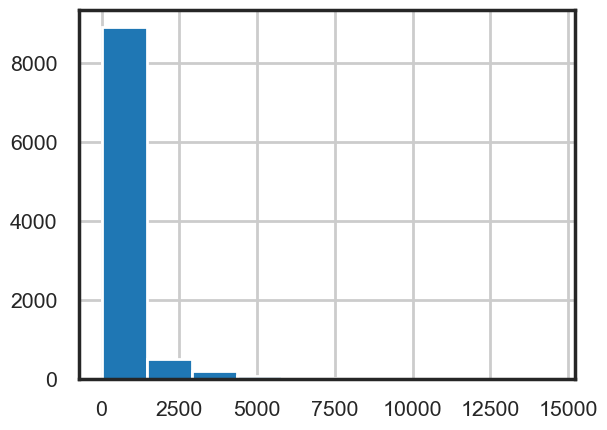

In [21]:
# Plot a histogram of the values in sorted_occupied_count
sorted_occupied_count.hist()
plt.show()

In [22]:
# Get the average rating for each user 
avg_ratings = user_ratings_df.mean(axis=1)

# Center each user's ratings around 0
user_ratings_centered = user_ratings_df.sub(avg_ratings, axis=1)

# Fill in all missing values with 0s
user_ratings_centered.fillna(0, inplace=True)

# Print the mean of each column
print(user_ratings_centered.mean(axis=1))

user_id
5        0.0
7        0.0
11       0.0
14       0.0
17       0.0
        ... 
73503    0.0
73504    0.0
73507    0.0
73510    0.0
73515    0.0
Length: 19949, dtype: float64


In [23]:
# Check if the matrix is non-zero after centering
if not user_ratings_centered.values.any():
    print("Matrix is entirely zeros after centering. Consider adjusting the centering method.")
    
    user_ratings_standardized = user_ratings_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
    user_ratings_standardized.fillna(0, inplace=True)

    # Convert to NumPy array
    user_ratings_standardized_matrix = user_ratings_standardized.values

    # Perform SVD on the standardized matrix
    U, sigma, Vt = svds(user_ratings_standardized_matrix, k=6)
    sigma = np.diag(sigma)
    print(sigma)
    
else:
    # Perform SVD with a higher k value
    U, sigma, Vt = svds(user_ratings_centered.values, k=6)
    sigma = np.diag(sigma)
    print(sigma)


Matrix is entirely zeros after centering. Consider adjusting the centering method.
[[162.74928879   0.           0.           0.           0.
    0.        ]
 [  0.         178.88803596   0.           0.           0.
    0.        ]
 [  0.           0.         192.57277856   0.           0.
    0.        ]
 [  0.           0.           0.         209.11043793   0.
    0.        ]
 [  0.           0.           0.           0.         252.99338553
    0.        ]
 [  0.           0.           0.           0.           0.
  523.08214387]]


In [24]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

# Add the row means back contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)

In [25]:
# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=user_ratings_df.index,
                                    columns=user_ratings_df.columns
                                   )
# Print both the recalculated matrix and the original 
calc_pred_ratings_df

name,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
5,4.346937,4.347787,4.327546,4.350323,4.351012,4.341972,4.275695,4.350805,4.348157,4.347511,...,4.347548,4.347770,4.347269,4.347856,4.364947,4.391107,4.360330,4.387418,4.360970,4.346996
7,7.386317,7.389035,7.381637,7.376713,7.383004,7.385637,7.328249,7.379393,7.388630,7.388904,...,7.388647,7.388744,7.402271,7.388880,7.405902,7.414700,7.397828,7.419258,7.412255,7.387336
11,7.326213,7.327080,7.321718,7.325099,7.325960,7.326172,7.328525,7.323552,7.327401,7.327157,...,7.327105,7.327325,7.321617,7.327114,7.373159,7.373587,7.349057,7.348210,7.348037,7.326635
14,7.196739,7.195400,7.197578,7.202171,7.200749,7.194533,7.148449,7.203199,7.195337,7.195269,...,7.195442,7.195247,7.178654,7.195119,7.177519,7.199861,7.189266,7.203840,7.193705,7.195851
17,6.895264,6.901264,6.873662,6.887339,6.894883,6.892260,6.797277,6.889273,6.901589,6.901163,...,6.900741,6.901778,6.911083,6.901119,6.982561,7.010273,6.949241,6.992868,6.966869,6.898332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,6.415125,6.417946,6.403108,6.411377,6.415020,6.414485,6.353806,6.411845,6.418648,6.418135,...,6.418069,6.418887,6.407408,6.418263,6.535875,6.538065,6.472473,6.479899,6.476858,6.417598
73504,7.827845,7.828290,7.823960,7.820185,7.824710,7.828008,7.771721,7.821494,7.828448,7.828387,...,7.828460,7.828461,7.820728,7.828710,7.920265,7.909163,7.860897,7.854236,7.863521,7.828624
73507,7.807465,7.813518,7.805725,7.794189,7.802241,7.811976,7.772851,7.793040,7.814474,7.814215,...,7.813861,7.815347,7.788136,7.813640,8.043970,8.031008,7.920271,7.914556,7.934691,7.812367


In [26]:
# Sort the ratings of User 5 from high to low
user_5_ratings = calc_pred_ratings_df.loc[17,:].sort_values(ascending=False)

print(user_5_ratings)

name
Steins;Gate                         8.941447
Fullmetal Alchemist: Brotherhood    8.622529
One Punch Man                       8.401329
Fate/Zero 2nd Season                8.309738
Tengen Toppa Gurren Lagann          8.215035
                                      ...   
Absolute Duo                        6.243497
Sword Art Online                    6.232386
Mahou Sensou                        6.220528
Glasslip                            6.122184
Pupa                                5.772368
Name: 17, Length: 9849, dtype: float64


In [27]:
act_ratings_df = user_ratings_df

avg_pred_ratings_df = pd.DataFrame(np.tile(avg_ratings.values, (user_ratings_df.shape[1], 1)).T, 
                                    index=user_ratings_df.index, 
                                    columns=user_ratings_df.columns)

# Extract the ground truth to compare your predictions against
actual_values = act_ratings_df.iloc[:20, :100].values
avg_values = avg_pred_ratings_df.iloc[:20, :100].values
predicted_values = calc_pred_ratings_df.iloc[:20, :100].values

# Create a mask of actual_values to only look at the non-missing values in the ground truth
mask = ~np.isnan(actual_values)

# Print the performance of both predictions and compare
print(mean_squared_error(actual_values[mask], avg_values[mask], squared=False))
print(mean_squared_error(actual_values[mask], predicted_values[mask], squared=False))

1.8161071794705785
1.7249423600454763


# **Item Based Collaborative Filtering KNN**

In [15]:
anime_df = anime_rating.copy()

### **Plot rating frequency of all movies**

In [ ]:
refined_dataset = anime_df[['user_id', 'name', 'user_rating']]
refined_dataset = refined_dataset.rename(columns={'user_id':'user id', 'name':'anime title'})

print(f'Shape of the movies_with_ratings dataframe: {refined_dataset.shape}')

refined_dataset.head(3)

Shape of the movies_with_ratings dataframe: (4762918, 3)


,user id,anime title,user_rating
0,99,Kimi no Na wa.,5.0
1,152,Kimi no Na wa.,10.0
2,244,Kimi no Na wa.,10.0


In [ ]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('anime title').size(), columns=['count'])
movies_count_df.head()

,count
anime title,
0,17
001,7
009 Re:Cyborg,216
009-1,208
009-1: RandB,86


Text(0, 0.5, 'number of ratings')

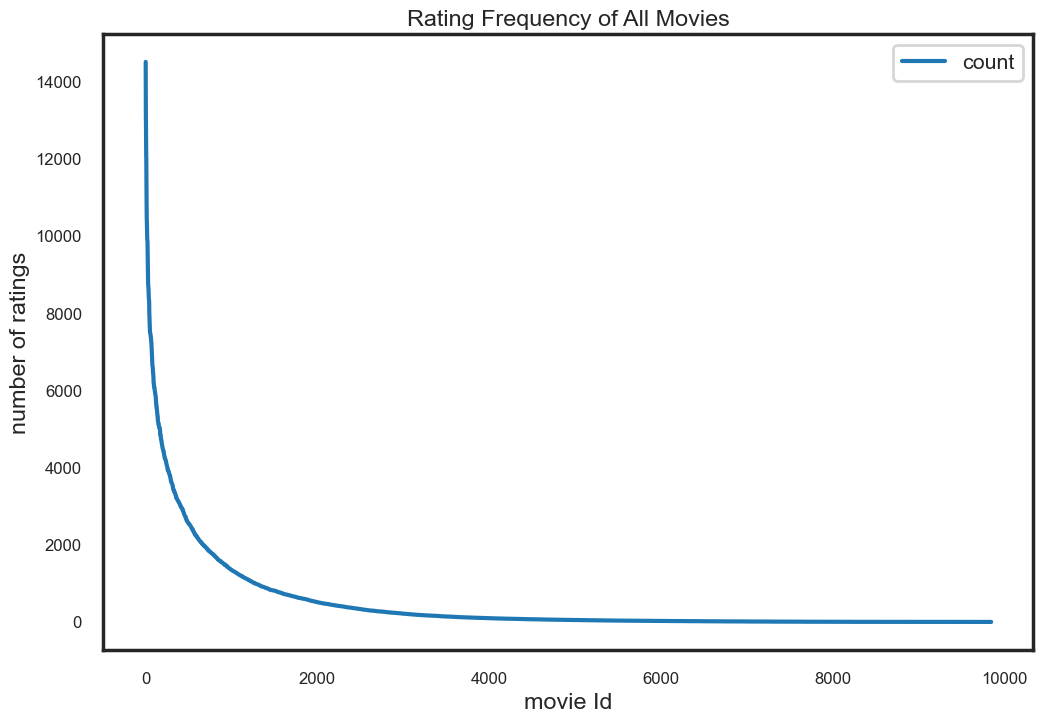

In [ ]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

**As the size of MovieLens dataset picked for this project is small. There is no need of removing rarely rated movies or users who has given rating for fewer movies.**

**Also because the dataset considered is small, we do not see the long-tail property which will be the scenario with the distribution of ratings.**

*If the dataset is larger, then* (this can be referred when we do similar kind of tasks with a larger dataset, just for future reference)

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

## **Training KNN model to build item-based collaborative Recommender System**

#### Movie Recommendation using KNN with Input as **User id**, Number of similar users should the model pick and Number of movies you want to get recommended:

In [19]:
# Handle duplicates by averaging the ratings
refined_dataset = refined_dataset.groupby(['user id', 'anime title'], as_index=False)['user_rating'].mean()

# Create the pivot table
user_to_movie_df = refined_dataset.pivot(
    index='user id',
    columns='anime title',
    values='user_rating'
).fillna(0)

user_to_movie_df.head()


anime title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<19949x9849 sparse matrix of type '<class 'numpy.float64'>'
	with 4754785 stored elements in Compressed Sparse Row format>

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [ ]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
    ## input to this function is the user and number of top similar users you want.

    knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
    # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


**Specify User id and Number of similar users we want to consider here**

In [25]:
from pprint import pprint
user_id = 17
print("Few of anime seen by the User:")
pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['anime title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

Few of anime seen by the User:
['91 Days',
 'Akame ga Kill!',
 'Akira',
 'Akuma no Riddle',
 'Aldnoah.Zero',
 'Aldnoah.Zero 2nd Season',
 'Amaama to Inazuma',
 'Amagami SS',
 'Amagami SS+ Plus',
 'Amagi Brilliant Park']
Top 5 users who are very much similar to the User- 17 are: 
 
1 . User: 4425 separated by distance of 0.502742767429408
2 . User: 9211 separated by distance of 0.5340855720679547
3 . User: 12924 separated by distance of 0.5388652503456045
4 . User: 9725 separated by distance of 0.5472604392641134
5 . User: 5313 separated by distance of 0.5486461963000924


**With the help of the KNN model built, we could get desired number of top similar users.**

**Now we will have to pick the top movies to recommend.**

**One way would be by taking the average of the existing ratings given by the similar users and picking the top 10 or 15 movies to recommend to our current user.**

**But I feel recommendation would be more effective if we define weights to ratings by each similar user based on the thier distance from the input user. Defining these weights would give us the accurate recommendations by eliminating the chance of decision manipulation by the users who are relatively very far from the input user.**

In [26]:
similar_user_list, distance_list

(array([ 4425,  9211, 12924,  9725,  5313], dtype=int64),
 array([0.50274277, 0.53408557, 0.53886525, 0.54726044, 0.5486462 ]))

In [27]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.18818039, 0.19991223, 0.2017013 , 0.20484369, 0.20536239])

Getting ratings of all movies by derived similar users

In [28]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
movies_list = user_to_movie_df.columns
movies_list

Index(['0', '001', '009 Re:Cyborg', '009-1', '009-1: RandB', '00:08',
       '07-Ghost', '1+2=Paradise', '100%',
       '100-man-nen Chikyuu no Tabi: Bander Book',
       ...
       'lilac (bombs Jun Togawa)', 'makemagic', 's.CRY.ed', 'vivi', 'xxxHOLiC',
       'xxxHOLiC Kei', 'xxxHOLiC Movie: Manatsu no Yoru no Yume',
       'xxxHOLiC Rou', 'xxxHOLiC Shunmuki', '◯'],
      dtype='object', name='anime title', length=9849)

In [30]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 9849)
Number of movies: 9849


**Broadcasting weightage matrix to similar user rating matrix. so that it gets compatible for matrix operations**

In [31]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 9849)

In [32]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
def recommend_movies(n):
    n = min(len(mean_rating_list),n)
    # print(np.argsort(mean_rating_list)[::-1][:n])
    pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))

In [35]:
print("Anime recommended based on similar users are: ")
recommend_movies(10)

Anime recommended based on similar users are: 
['Elfen Lied',
 'Another',
 'Kuroshitsuji',
 'Kuroshitsuji II',
 'Tokyo Ghoul',
 'Sword Art Online',
 'Kuroshitsuji: Book of Circus',
 'Ookami to Koushinryou',
 'Psycho-Pass',
 'Sakurasou no Pet na Kanojo']


**Above drawbacks are addressed and a new recommender system with modification is built**

Below function is defined to remove the movies which are already seen the current user and not at all seen by any of the similar users.

In [39]:
def filtered_movie_recommendations(n):
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['anime title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
        if i not in movies_watched:
            count+=1
            final_movie_list.append(i)
        if count == n:
            break
    if count == 0:
        print("There are no anime left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
        pprint(final_movie_list)

In [41]:
filtered_movie_recommendations(10)

['Ookami to Koushinryou',
 'Tasogare Otome x Amnesia',
 'Nana',
 'Inu x Boku SS',
 'Papa no Iukoto wo Kikinasai!',
 'Myself; Yourself',
 'Black Lagoon: The Second Barrage',
 'Ookami to Koushinryou II',
 'Uta no☆Prince-sama♪ Maji Love 2000%',
 'Uta no☆Prince-sama♪ Maji Love 1000%']


Coding up all of the above individual cells into a function.

Giving Input as **User id, Number of similar Users to be considered, Number of top movie we want to recommend**

In [45]:
def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['anime title']))
    print("")

    # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
    def get_similar_users(user, n = 5):
        
        knn_input = np.asarray([user_to_movie_df.values[user-1]])
        
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
        
        print("Top",n,"users who are very much similar to the User-",user, "are: ")
        print(" ")

        for i in range(1,len(distances[0])):
            print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
        print("")
        return indices.flatten()[1:] + 1, distances.flatten()[1:]

    def filtered_movie_recommendations(n = 10):
        first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        n = min(len(sortd_index),n)
        movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['anime title'])
        filtered_movie_list = list(movies_list[sortd_index])
        count = 0
        final_movie_list = []
        for i in filtered_movie_list:
            if i not in movies_watched:
                count+=1
                final_movie_list.append(i)
            if count == n:
                break
        if count == 0:
            print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
        else:
            pprint(final_movie_list)

    similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
    weightage_list = distance_list/np.sum(distance_list)
    mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
    movies_list = user_to_movie_df.columns
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list*mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis =0)
    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    filtered_movie_recommendations(n_movies)

In [46]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
number of similar users to be considered
Enter number of movies to be recommended:
Movie seen by the User:
['91 Days',
 'Akame ga Kill!',
 'Akira',
 'Akuma no Riddle',
 'Aldnoah.Zero',
 'Aldnoah.Zero 2nd Season',
 'Amaama to Inazuma',
 'Amagami SS',
 'Amagami SS+ Plus',
 'Amagi Brilliant Park',
 'Angel Beats!',
 'Anime de Wakaru Shinryounaika',
 'Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.',
 'Another',
 'Ansatsu Kyoushitsu (TV)',
 'Ao Haru Ride',
 'Arslan Senki (TV)',
 'Azumanga Daioh',
 'Baccano!',
 'Baka to Test to Shoukanjuu',
 'Bakemono no Ko',
 'Bakemonogatari',
 'Barakamon',
 'Bayonetta: Bloody Fate',
 'Ben-To',
 'Black Bullet',
 'Black Lagoon',
 'Black★Rock Shooter (OVA)',
 'Blood Lad',
 'Boku dake ga Inai Machi',
 'Boku no Hero Academia',
 'Boku wa Tomodachi ga Sukunai',
 'Boku wa Tomodachi ga Sukunai Next',
 'Bokura wa Minna Kawaisou',
 'Buki yo Saraba',
 'Byousoku 5 Centimeter',
 'Captain Harlock',
 'Cencoroll',
 'Charlotte',
 'Chuunibyou demo Koi 

## Movie Recommendation using KNN with Input as **Movie Name** and Number of movies you want to get recommended:

2. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.

 We will train the KNN model inorder to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.

In [51]:
# Handle duplicates by averaging the ratings
refined_dataset = refined_dataset.groupby(['user id', 'anime title'], as_index=False)['user_rating'].mean()

# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
    index='anime title',
    columns='user id',
    values='user_rating').fillna(0)

movie_to_user_df.head()

user id,5,7,11,14,17,21,29,38,43,44,...,73494,73495,73499,73500,73502,73503,73504,73507,73510,73515
anime title,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009 Re:Cyborg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1: RandB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<9849x19949 sparse matrix of type '<class 'numpy.float64'>'
	with 4754785 stored elements in Compressed Sparse Row format>

Extracting movie names into a list:

In [53]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

['0',
 '001',
 '009 Re:Cyborg',
 '009-1',
 '009-1: RandB',
 '00:08',
 '07-Ghost',
 '1+2=Paradise',
 '100%',
 '100-man-nen Chikyuu no Tabi: Bander Book']

Creating a dictionary with movie name as key and its index from the list as value:

In [54]:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
# print(movie_dict)

In [55]:
case_insensitive_movies_list = [i.lower() for i in movies_list]

Fitting a KNN model:

In [56]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [57]:
## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
    ## input to this function is the movie and number of top similar movies you want.
    index = movie_dict[movie]
    knn_input = np.asarray([movie_to_user_df.values[index]])
    n = min(len(movies_list)-1,n)
    distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(movies_list[indices[0][i]])

Testing the recommender system with basic input with the movie names

In [58]:
from pprint import pprint
movie_name = 'Steins;Gate'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- Steins;Gate are: 
 
Angel Beats!
Shingeki no Kyojin
Steins;Gate: Oukoubakko no Poriomania
Sword Art Online
Mirai Nikki (TV)
Death Note
Code Geass: Hangyaku no Lelouch
Bakemonogatari
Fate/Zero
Code Geass: Hangyaku no Lelouch R2
Fullmetal Alchemist: Brotherhood
Toradora!
Steins;Gate Movie: Fuka Ryouiki no Déjà vu
Fate/Zero 2nd Season
Psycho-Pass


**Dynamically suggesting** movie name from the existing movie corpus we have, based on the user input using try and except architecture.

Defining a function which outputs movie names as suggestion when the user mis spells the movie name. **User might have intended to type any of these movie names.**

In [59]:
def get_possible_movies(movie):
    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()
    return possible_movies

This function provides user with **movie name suggestions if movie name is mis-spelled** or **Recommends similar movies to the input movie** if the movie name is valid.

In [60]:
class invalid(Exception):
    pass

def spell_correction():
    try:

      movie_name = input("Enter the Anime name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(movies_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(movies_list) :
        print("Anime name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Anime name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
        spell_correction()


In [61]:
spell_correction()

Top 15 movies which are very much similar to the Movie- Steins;Gate are: 
 
Angel Beats!
Shingeki no Kyojin
Steins;Gate: Oukoubakko no Poriomania
Sword Art Online
Mirai Nikki (TV)
Death Note
Code Geass: Hangyaku no Lelouch
Bakemonogatari
Fate/Zero
Code Geass: Hangyaku no Lelouch R2
Fullmetal Alchemist: Brotherhood
Toradora!
Steins;Gate Movie: Fuka Ryouiki no Déjà vu
Fate/Zero 2nd Season
Psycho-Pass


Observation on above built KNN Recommender System:

An interesting observation would be that the above KNN model for movies recommends movies that are produced in very similar years of the input movie. However, the cosine distance of all those recommendations are observed to be actually quite small. This might be because there are too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart. So I'd like to dig deeper and look closer inside our data.

Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [62]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 97.58% of ratings in our data is missing


In [100]:
query_no = np.random.choice(movie_to_user_df.shape[0]) # random anime title and finding recommendation
print(f"We will find recommendation for {query_no} no anime which is {movie_to_user_df.index[query_no]}.")
distances, indices = knn_movie_model.kneighbors(movie_to_user_df.iloc[query_no,:].values.reshape(1, -1), n_neighbors = 6)

We will find recommendation for 5936 no anime which is Nagagutsu Sanjuushi.


In [101]:
no = []
name = []
distance = []
rating = []

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {movie_to_user_df.index[query_no]} viewers :\n")
    else:
        #  print(f"{i}: {movie_to_user_df.index[indices.flatten()[i]]} , with distance of {distances.flatten()[i]}")        
        no.append(i)
        name.append(movie_to_user_df.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(*anime[anime["name"]==movie_to_user_df.index[indices.flatten()[i]]]["rating"].values)

dic = {"No" : no, "Anime Name" : name, "Rating" : rating}
recommendation = pd.DataFrame(data = dic)
recommendation.set_index("No", inplace = True)
recommendation.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Recommendations for Nagagutsu Sanjuushi viewers :



,Anime Name,Rating
No,,
1,Nagagutsu wo Haita Neko: 80 Nichikan Sekai Isshuu,7.200000
2,Nagagutsu wo Haita Neko,7.180000
3,Omoide no Album,5.140000
4,Nobiro Nobiro Daisuki na Ki,6.060000
5,Message Song,5.550000


# **Softmax DNN**

In [81]:
anime_df = anime_rating.copy()

In [82]:
refined_dataset = anime_df[['user_id', 'name', 'user_rating']]
refined_dataset = refined_dataset.rename(columns={'user_id':'user id', 'name':'anime title', 'user_rating':'rating'})

refined_dataset = refined_dataset.groupby(by=['user id','anime title'], as_index=False).agg({"rating":"mean"})


print(f'Shape of the anime_with_ratings dataframe: {refined_dataset.shape}')

refined_dataset.head(3)

Shape of the anime_with_ratings dataframe: (4754785, 3)


,user id,anime title,rating
0,5,Absolute Duo,2.0
1,5,Accel World,3.0
2,5,Akame ga Kill!,4.0


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [83]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [84]:
item_enc = LabelEncoder()
refined_dataset['anime'] = item_enc.fit_transform(refined_dataset['anime title'].values)
n_movies = refined_dataset['anime'].nunique()

In [85]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(19949, 9849, 1.0, 10.0)

In [86]:
refined_dataset.head()

,user id,anime title,rating,user,anime
0,5,Absolute Duo,2.0,0,96
1,5,Accel World,3.0,0,98
2,5,Akame ga Kill!,4.0,0,219
3,5,Akira,8.0,0,244
4,5,Amaama to Inazuma,7.0,0,277


## Splitting the data into training and testing

In [87]:
from sklearn.model_selection import train_test_split

X = refined_dataset[['user', 'anime']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4279306, 2), (475479, 2), (4279306,), (475479,))

## Defining number of factors which are to be considered by the Embedding layer

In [88]:
n_factors = 150

Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [89]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [90]:
X_train, X_train_array, X_train_array[0].shape

(array([[17995,  4945],
        [17828,  2185],
        [14816,  9429],
        ...,
        [ 2844,  5654],
        [ 4951,  3502],
        [ 8300,   569]], dtype=int64),
 [array([17995, 17828, 14816, ...,  2844,  4951,  8300], dtype=int64),
  array([4945, 2185, 9429, ..., 5654, 3502,  569], dtype=int64)],
 (4279306,))

## Normalizing the labels

In [91]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Building a Softmax Deep Neural Network

In [92]:
# Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

# Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [93]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 150)    │  2,992,350 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 150)    │  1,477,350 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 150)       │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 150)       │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 300)       │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 300)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      9,632 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32)        │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16)        │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 16)        │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 9)         │        153 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 9)         │          0 │ dense_5[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,480,013 (17.09 MB)

 Trainable params: 4,480,013 (17.09 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=80, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/80
33433/33433 ━━━━━━━━━━━━━━━━━━━━ 382s 11ms/step - accuracy: 0.0028 - loss: 0.4196 - val_accuracy: 0.0028 - val_loss: 0.3546 - learning_rate: 0.0100
Epoch 2/80
 2538/33433 ━━━━━━━━━━━━━━━━━━━━ 5:34 11ms/step - accuracy: 0.0031 - loss: 0.3563

KeyboardInterrupt: 

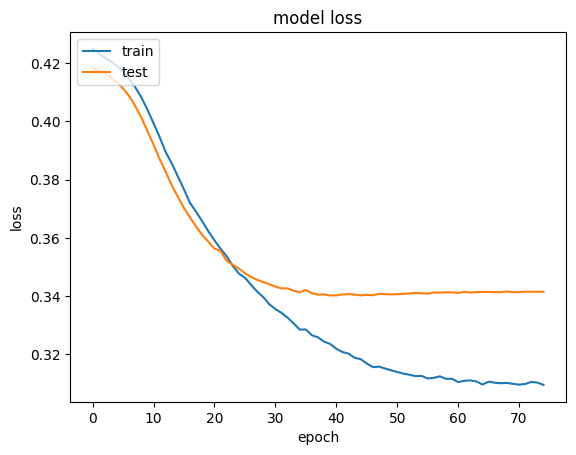

In [232]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Above is the model input shape

In [233]:
user_id = [600]
encoded_user_id = user_enc.transform(user_id)
seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['anime'])
unseen_movies = [i for i in range(min(refined_dataset['anime']), max(refined_dataset['anime'])+1) if i not in seen_movies]
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]

**DNN model is used to predict the ratings of the unseen movies.**

In [234]:
predicted_ratings = model.predict(model_input)

print(predicted_ratings.shape)
predicted_ratings

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
(8719, 9)


array([[8.4660614e-01, 1.5320842e-01, 1.0450844e-05, ..., 2.3197446e-05,
        1.8402514e-05, 1.7161048e-05],
       [8.7015182e-01, 1.2967022e-01, 1.0883064e-05, ..., 2.2476097e-05,
        1.7610764e-05, 1.7388355e-05],
       [6.6443676e-01, 3.3526111e-01, 1.3506925e-05, ..., 3.3531203e-05,
        3.0457259e-05, 2.5441583e-05],
       ...,
       [8.2783145e-01, 1.7197871e-01, 1.0368562e-05, ..., 2.2890170e-05,
        1.8843637e-05, 1.7720555e-05],
       [6.4230978e-01, 3.5736302e-01, 1.4319640e-05, ..., 3.4902729e-05,
        3.2811477e-05, 2.7004635e-05],
       [8.6348426e-01, 1.3634217e-01, 1.0205199e-05, ..., 2.1695580e-05,
        1.7231057e-05, 1.6384261e-05]], dtype=float32)

In [235]:
predicted_ratings = np.max(predicted_ratings, axis=1)

print(predicted_ratings.shape)
predicted_ratings

(8719,)


array([0.84660614, 0.8701518 , 0.66443676, ..., 0.82783145, 0.6423098 ,
       0.86348426], dtype=float32)

Index of ratings sorted by descending order.

In [236]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[2962 1513 8403 ... 3225 4726 4758]


**Movie names have been extracted from the available indices we got.**

In [237]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Home Alone 4', 'Confessions', 'Walk on Water', ...,
       'Inherent Vice', "Pan's Labyrinth", "Paris, je t'aime"],
      dtype=object)

### Movies recommended with the help of Softmax Deep Neural Networks

In [238]:
from pprint import pprint

pprint(list(recommended_movies[:20]))

['Home Alone 4',
 'Confessions',
 'Walk on Water',
 'Source Code',
 'Cobra',
 'Jules and Jim',
 'Ernest Goes to Camp',
 'Freaky Friday',
 'Bat*21',
 'City Hall',
 'Police Academy 6: City Under Siege',
 'The Man Who Fell to Earth',
 'Les Girls',
 'Backdraft',
 'Dirty Mary Crazy Larry',
 'Frankie Starlight',
 'Les Amants du Pont-Neuf',
 'Just My Luck',
 'Maximum Conviction',
 'Betty Fisher and Other Stories']


### Summing up the entire code into a recommender system function:

In [239]:
def recommender_system(user_id, model, n_movies):
    print("")
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
    print("")

    encoded_user_id = user_enc.transform([user_id])

    seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
    unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
    model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
    predicted_ratings = model.predict(model_input)
    predicted_ratings = np.max(predicted_ratings, axis=1)
    sorted_index = np.argsort(predicted_ratings)[::-1]
    recommended_movies = item_enc.inverse_transform(sorted_index)
    print("---------------------------------------------------------------------------------")
    print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
    pprint(list(recommended_movies[:n_movies]))

In [240]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
Enter number of movies to be recommended:

Movie seen by the User:
['Air Force One',
 'Aladdin',
 'American Beauty',
 'Apollo 13',
 'Armageddon',
 'Austin Powers: The Spy Who Shagged Me',
 'Back to the Future Part III',
 'Batman & Robin',
 'Blade',
 'Braveheart',
 'Cast Away',
 'Close Encounters of the Third Kind',
 'Crouching Tiger, Hidden Dragon',
 'Dark City',
 'Die Hard 2',
 'Dracula',
 'Forrest Gump',
 'Gladiator',
 'Indiana Jones and the Last Crusade',
 'Jurassic Park',
 'Lethal Weapon 2',
 'Lethal Weapon 4',
 'Mars Attacks!',
 'Minority Report',
 'Mission: Impossible II',
 'Planet of the Apes',
 'Raiders of the Lost Ark',
 'Return of the Jedi',
 'RoboCop',
 'Sleepy Hollow',
 'Star Wars',
 'Star Wars: Episode I - The Phantom Menace',
 'Terminator 2: Judgment Day',
 'That Thing You Do!',
 'The Exorcist',
 'The Fifth Element',
 'The Game',
 'The Green Mile',
 'The Mask of Zorro',
 'The Mummy',
 'The Patriot',
 'The Rock',
 'The Silence of the Lambs',
 'Twelve Monkeys'